Following Topics will be covered in Preprocessing of the data:
1. Reading the data and source documentation to get it in the right structure


2. Exploration: histograms, variance, value counts


3. Removing Missing Data:
    
    </t>a) Identify rows of missing data 

    </t>b) Columns- Those that have low variance, redundance, or missing values that can not be imputed


4. Changing Data Types


5. Train-test-validate splitting before handling missing data- using imbalanced class splitting


6. Feature Engineering:

    </t>a) Encoding Categorical Columns

    </t>b) Feature Extraction (Adding more columns)- for numerical and text

    </t>c) Feature Selection- Dimensionality Reduction
    
    
7. Classification


8. Grid Search


9. Building Pipelines

In [31]:
import pandas as pd
import numpy as np
import os
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Data

Input data - Diabetes 130-US hospitals for years 1999-2008 Data Set
URL: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. 

It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.
(1) It is an inpatient encounter (a hospital admission).
(2) It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
(3) The length of stay was at least 1 day and at most 14 days.
(4) Laboratory tests were performed during the encounter.
(5) Medications were administered during the encounter.
The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

Analysis: Impact of measurements on Hospital Readmission.

In [32]:
INPUT_DATA_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'DATA', 'Input', 'dataset_diabetes')
OUTPUT_DATA_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'DATA', 'Output')
files_ = []
for root, dirs, files in os.walk(INPUT_DATA_PATH):
    for filename in files:
        RAW_DATA = os.path.join(INPUT_DATA_PATH, filename)
        try: 
            if '.csv' in filename or '.data' in filename or '.xlsx' in filename:
                files_.append(RAW_DATA)
                print("%s: %d bytes"%(filename, os.path.getsize(RAW_DATA)))
        except FileNotFoundError:
            break
print(INPUT_DATA_PATH,"\t", OUTPUT_DATA_PATH)


IDs_mapping.csv: 2547 bytes
diabetic_data.csv: 19159383 bytes
/Users/gaurikatyagi/Documents/ML/DATA/Input/dataset_diabetes 	 /Users/gaurikatyagi/Documents/ML/DATA/Output


Let us read these files and see what they contain

In [33]:
for data_file in files_:
    print("File:", data_file)
    input_data = pd.read_csv(data_file)
    print("Input data shape:", input_data.shape)
    display(HTML(input_data.head(5).to_html()))
    display(HTML(input_data.describe().to_html()))
    print(input_data.dtypes)
    print("\n\n")


File: /Users/gaurikatyagi/Documents/ML/DATA/Input/dataset_diabetes/IDs_mapping.csv
Input data shape: (67, 2)


,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


,admission_type_id,description
count,65,62
unique,32,58
top,7,Unknown/Invalid
freq,3,2


admission_type_id    object
description          object
dtype: object



File: /Users/gaurikatyagi/Documents/ML/DATA/Input/dataset_diabetes/diabetic_data.csv
Input data shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

So, the admission type_id is encoded as a numeric and kept in a separate table. Let us join these files together and drop the id. For any sort of ML, we will need for it to be one-hot encoded, not numeric. 

We will need additional prepocessing (notice the '?' in weights, payer_code, medical_specialty etc.)

#### Concatenation

In [34]:
diabetes_data = pd.read_csv(os.path.join(INPUT_DATA_PATH, 'diabetic_data.csv'))
admission_type_data = pd.read_csv(os.path.join(INPUT_DATA_PATH, 'IDs_mapping.csv'))
diabetes_data = diabetes_data.join(admission_type_data, 
                                   on = 'admission_type_id', 
                                   how = 'left', 
                                   rsuffix = "admission_")


In [35]:
diabetes_data.drop([value for index, value in enumerate(diabetes_data.columns) 
                    if 'admission_type_id' in value]
                   , axis = 1
                   , inplace = True
                  )
diabetes_data.rename(columns={"description": "admission_type"}, inplace = True)
diabetes_data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_type'],
      dtype='object')

## Data Exploration


### Identifier Columns -
We want to first see whether it makes sense to retain the patient_nbr and encounter_id. Let us examine if we have multiple encounters per patient. 

In [36]:
diabetes_data.groupby('patient_nbr').count().reset_index().iloc[:,0:2].sort_values(by = 'encounter_id', 
                                                                                   ascending=False
                                                                                  ).head(3)

,patient_nbr,encounter_id
54474,88785891,40
32927,43140906,28
3515,1660293,23


Yes, we do. But, does it mean anything to maintain the relationship? Let us extract one of these patients and see if individual rows are enough for every predcition.

In [37]:
diabetes_data.loc[diabetes_data.patient_nbr == 88785891, :].head(5)

,encounter_id,patient_nbr,race,gender,age,weight,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type
38307,119039172,88785891,Caucasian,Female,[20-30),?,1,7,1,OG,...,Up,No,No,No,No,No,Ch,Yes,>30,Urgent
40252,125094312,88785891,Caucasian,Female,[20-30),?,1,7,1,BC,...,Down,No,No,No,No,No,Ch,Yes,<30,Urgent
40661,126171582,88785891,Caucasian,Female,[20-30),?,1,7,5,BC,...,Up,No,No,No,No,No,Ch,Yes,>30,Urgent
44515,137245596,88785891,Caucasian,Female,[20-30),?,1,7,2,SP,...,Up,No,No,No,No,No,Ch,Yes,<30,Newborn
45147,139425576,88785891,Caucasian,Female,[20-30),?,1,7,2,BC,...,Up,No,No,No,No,No,Ch,Yes,<30,Urgent


Seems like for every visit, the data records the patient's history till then. Perfect, means we can <b>drop</b> these columns for this study: 
1. encounter_id	
2. patient_nbr

### Data Type Change

<b>Columns with no real numerical meaning:</b>
1. encounter_id	 - identified to drop
2. patient_nbr	- identified to drop
3. discharge_disposition_id: under what status is the patient being discharged- at home care, transferred etc.
4. admission_source_id: how was the patient admitted- urgent, elective etc.

In [38]:
diabetes_data.loc[:,['discharge_disposition_id', 'admission_source_id']]= \
                                            diabetes_data.loc[:, ['discharge_disposition_id', 'admission_source_id']
                                                            ].astype(str)

In [39]:
diabetes_data.describe()

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


### Missing values

#### Categorical Data

Number of categorical columns:  40
Columns with NAN values:  Index(['admission_type'], dtype='object')
---------Exploring Categorical Columns-----------


Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64


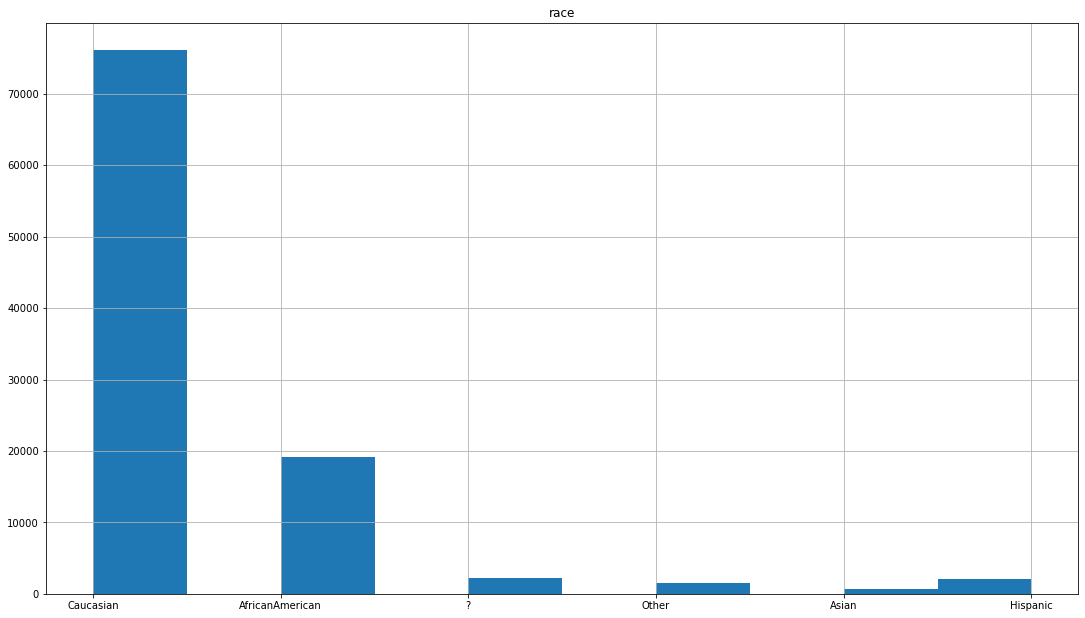

	*****
Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64


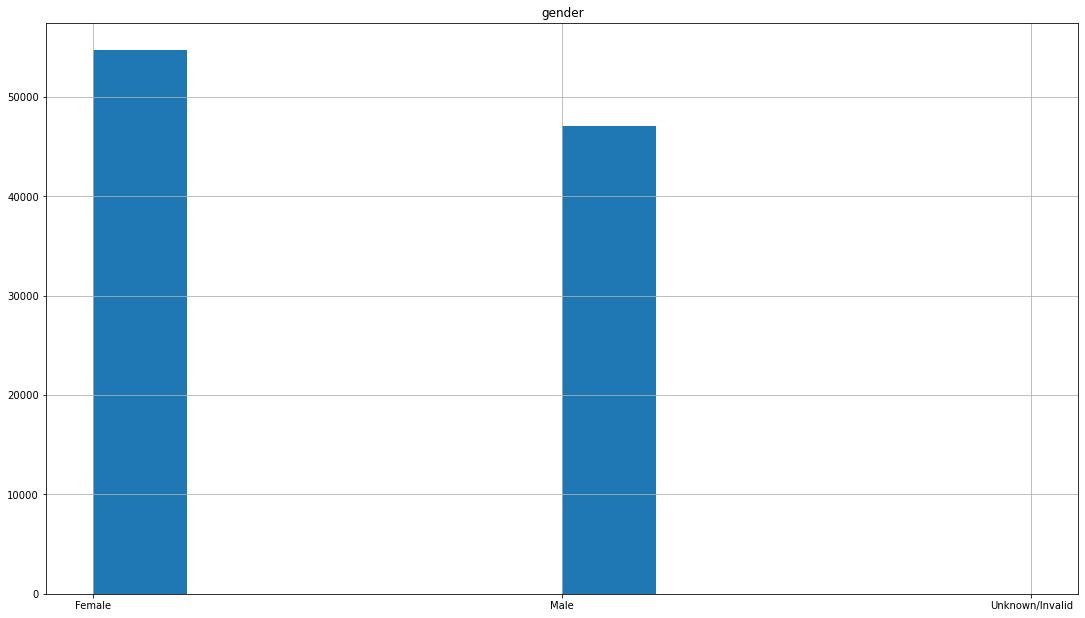

	*****
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64


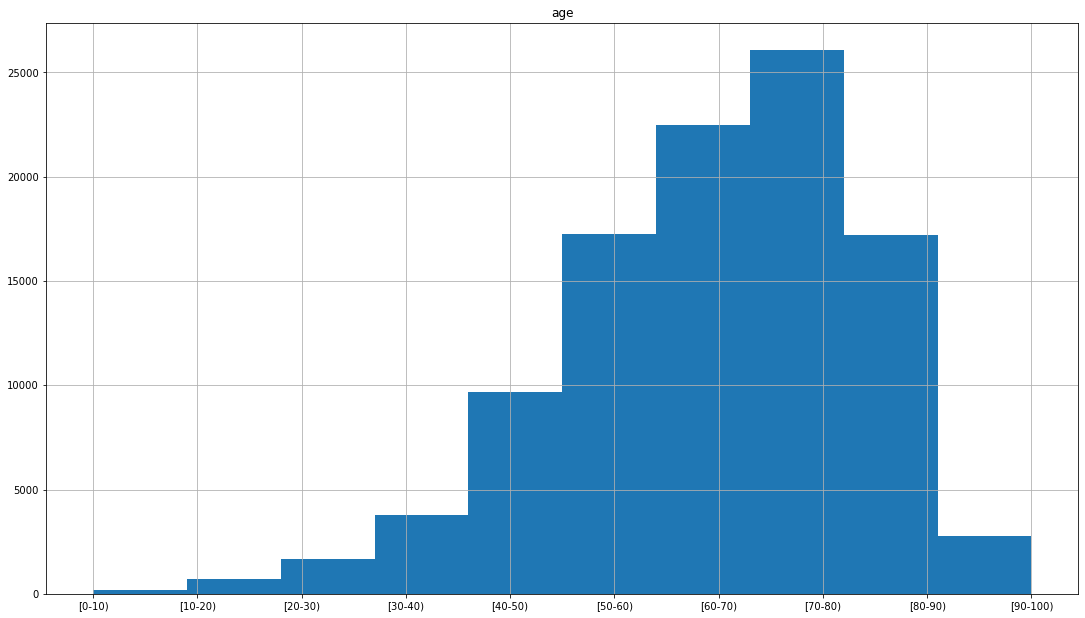

	*****
?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64


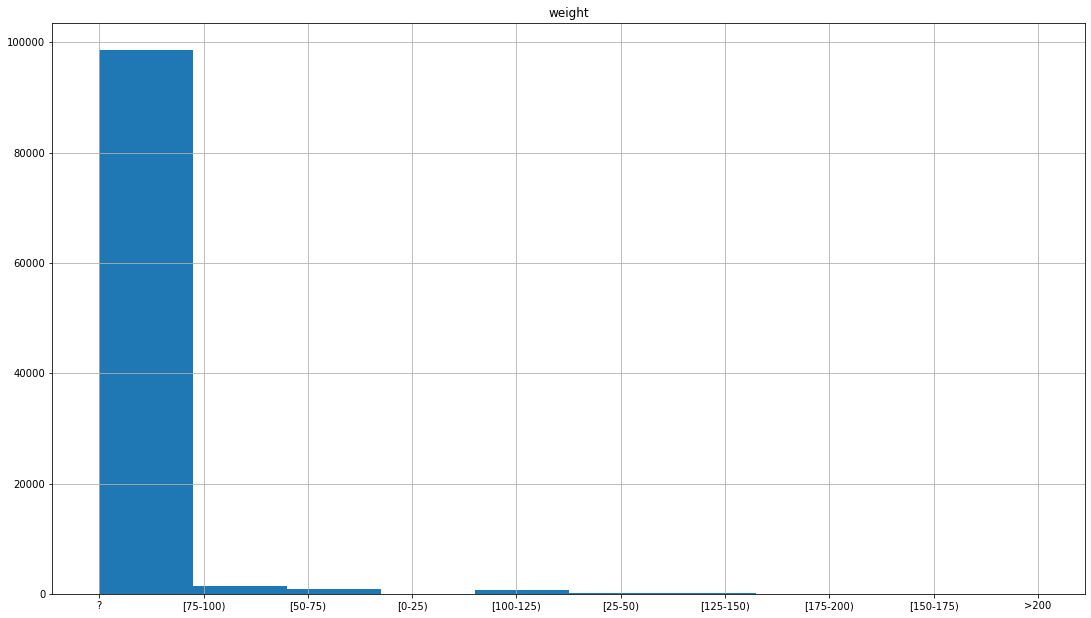

	*****
1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64


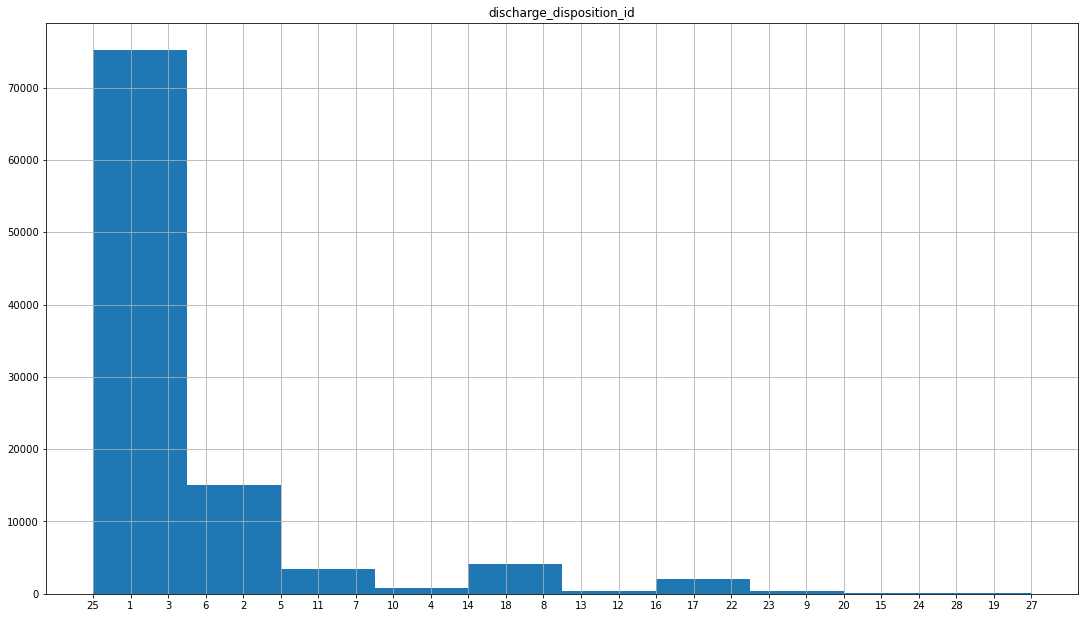

	*****
7     57494
1     29565
17     6781
4      3187
6      2264
2      1104
5       855
3       187
20      161
9       125
8        16
22       12
10        8
11        2
25        2
14        2
13        1
Name: admission_source_id, dtype: int64


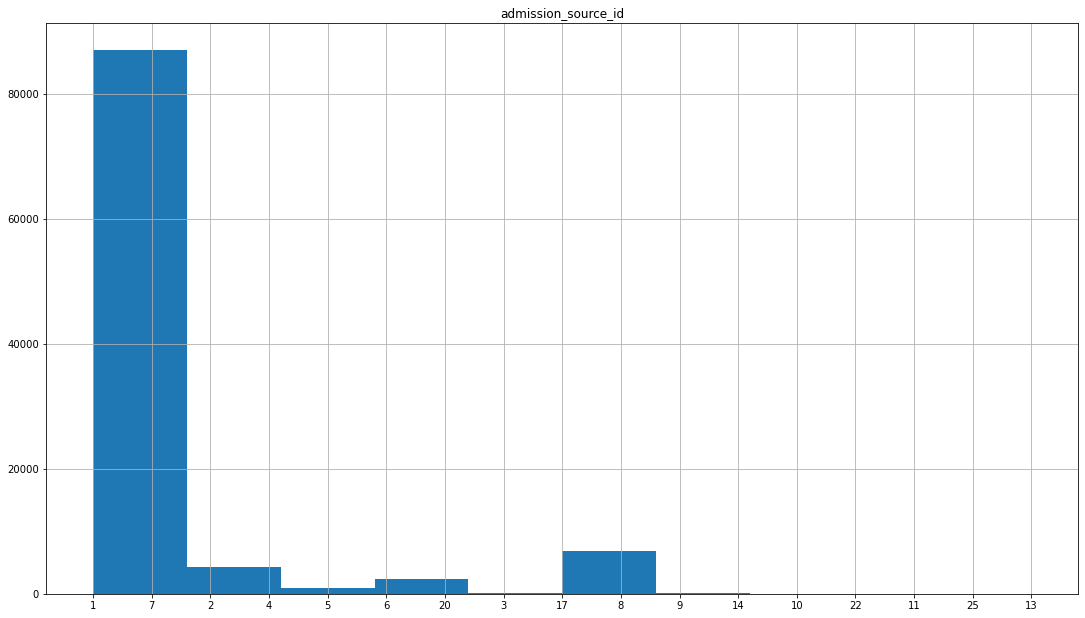

	*****
?     40256
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: payer_code, dtype: int64


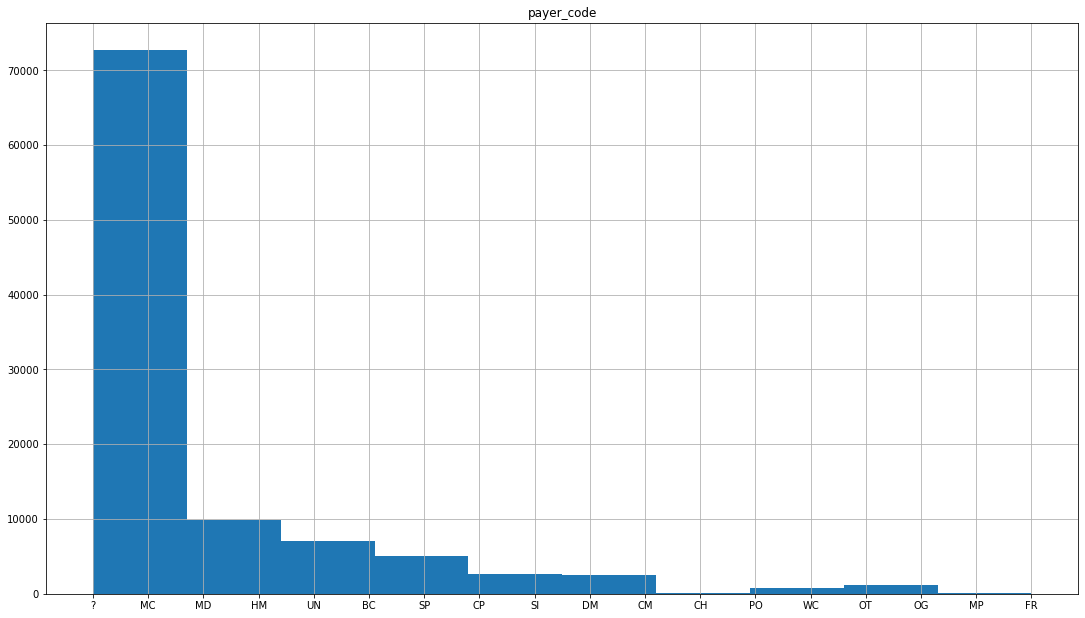

	*****
?                                49949
InternalMedicine                 14635
Emergency/Trauma                  7565
Family/GeneralPractice            7440
Cardiology                        5352
                                 ...  
Proctology                           1
SportsMedicine                       1
Pediatrics-InfectiousDiseases        1
Dermatology                          1
Psychiatry-Addictive                 1
Name: medical_specialty, Length: 73, dtype: int64


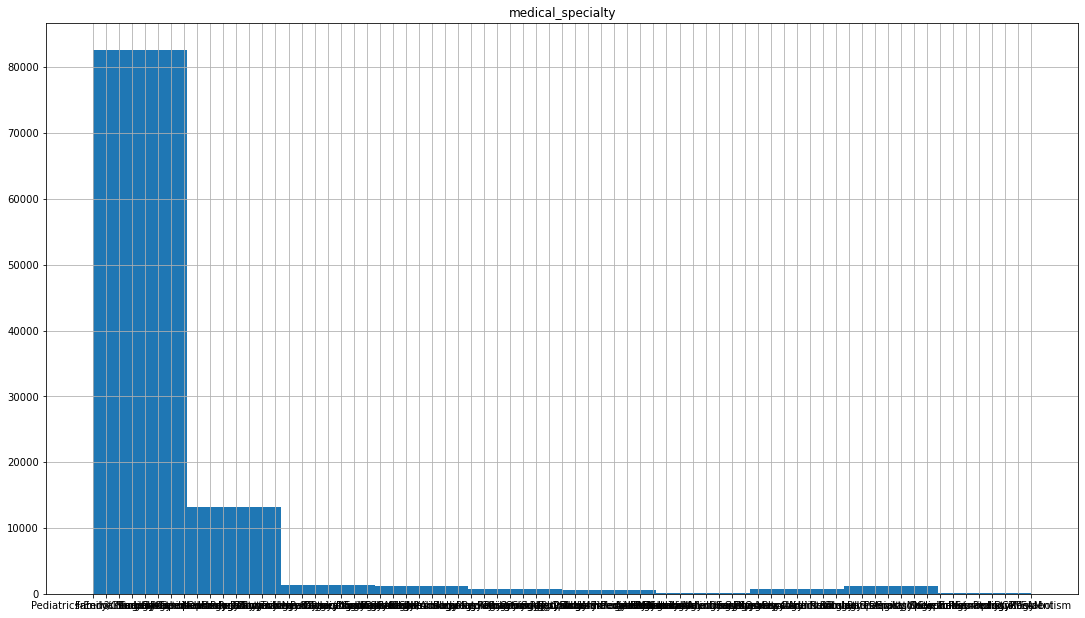

	*****
428    6862
414    6581
786    4016
410    3614
486    3508
       ... 
347       1
605       1
207       1
870       1
842       1
Name: diag_1, Length: 717, dtype: int64


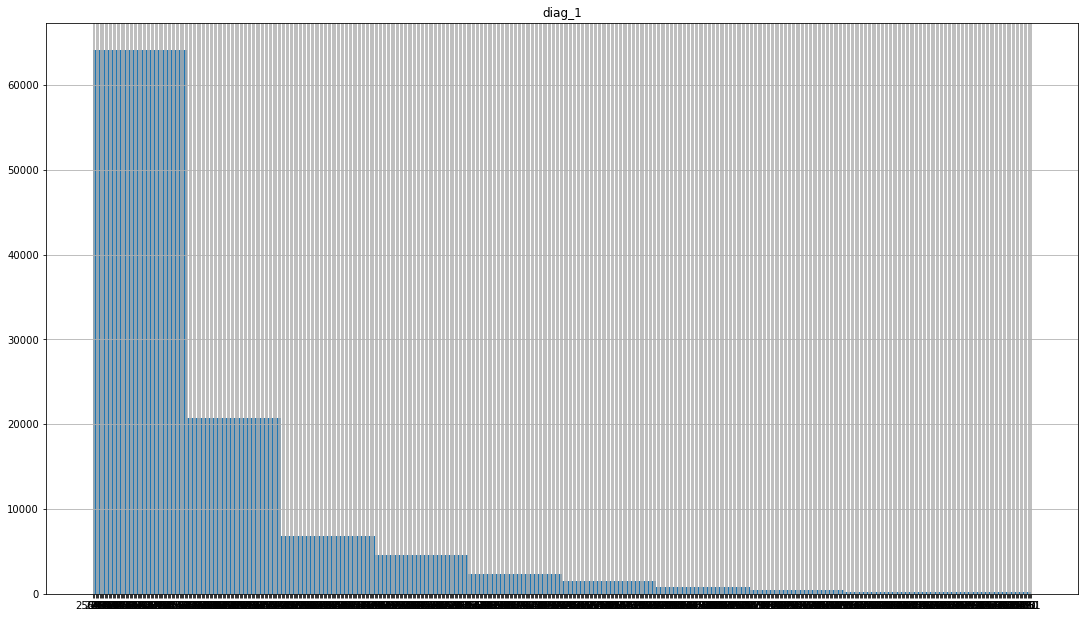

	*****
276     6752
428     6662
250     6071
427     5036
401     3736
        ... 
E918       1
V50        1
347        1
E882       1
703        1
Name: diag_2, Length: 749, dtype: int64


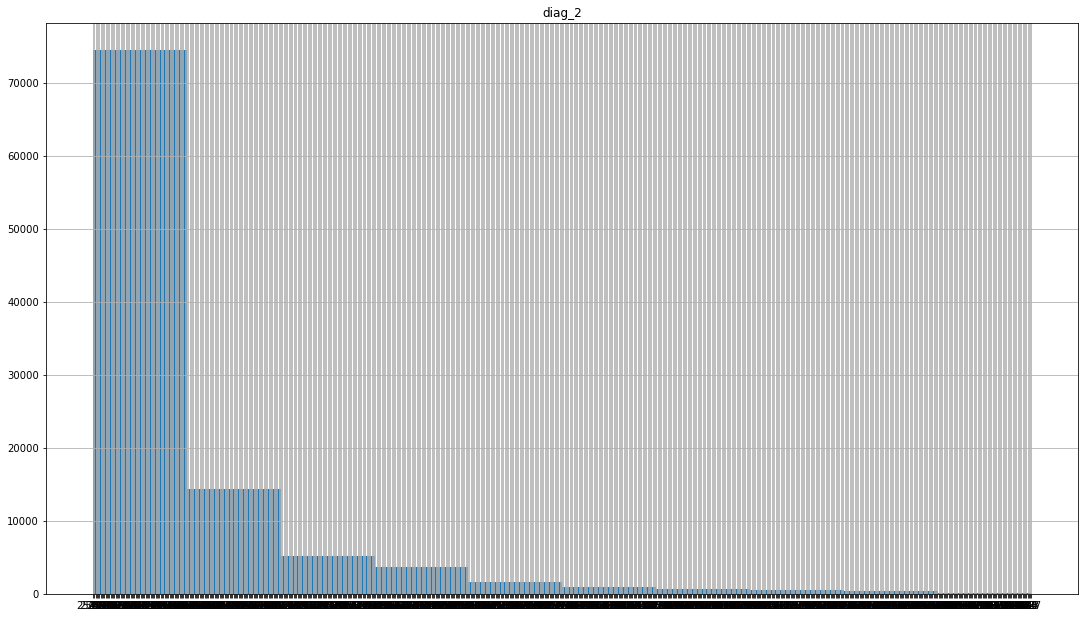

	*****
250     11555
401      8289
276      5175
428      4577
427      3955
        ...  
E882        1
744         1
622         1
875         1
E865        1
Name: diag_3, Length: 790, dtype: int64


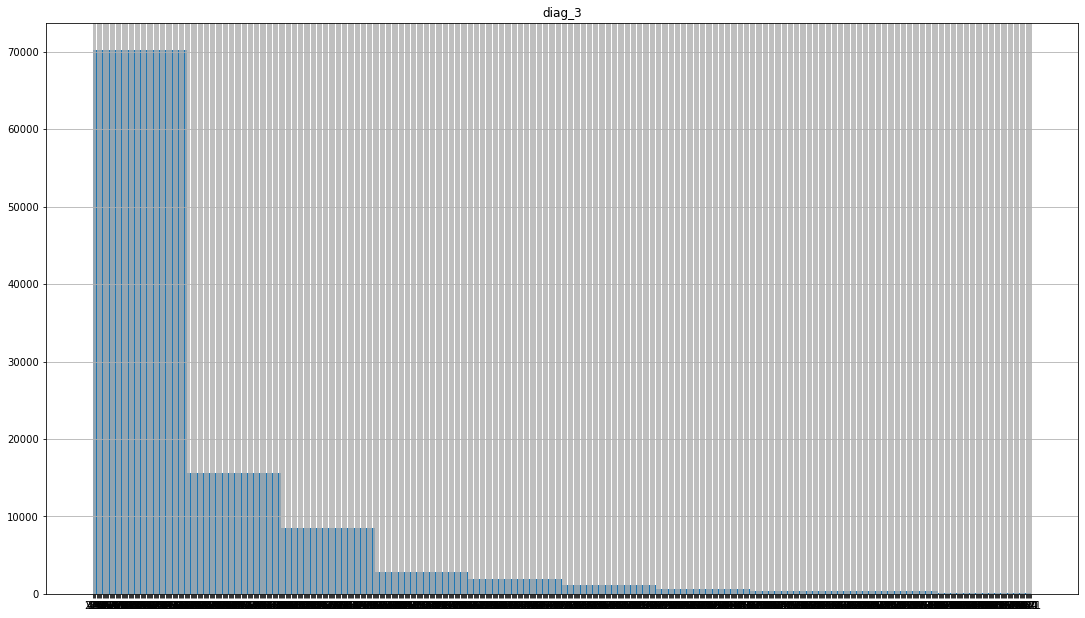

	*****
None    96420
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64


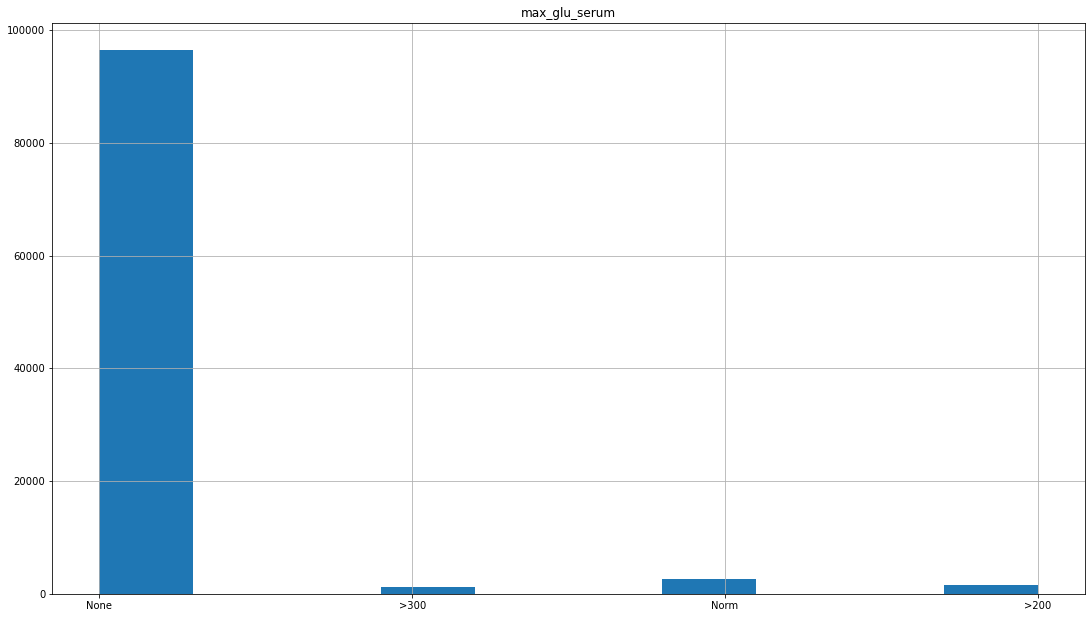

	*****
None    84748
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64


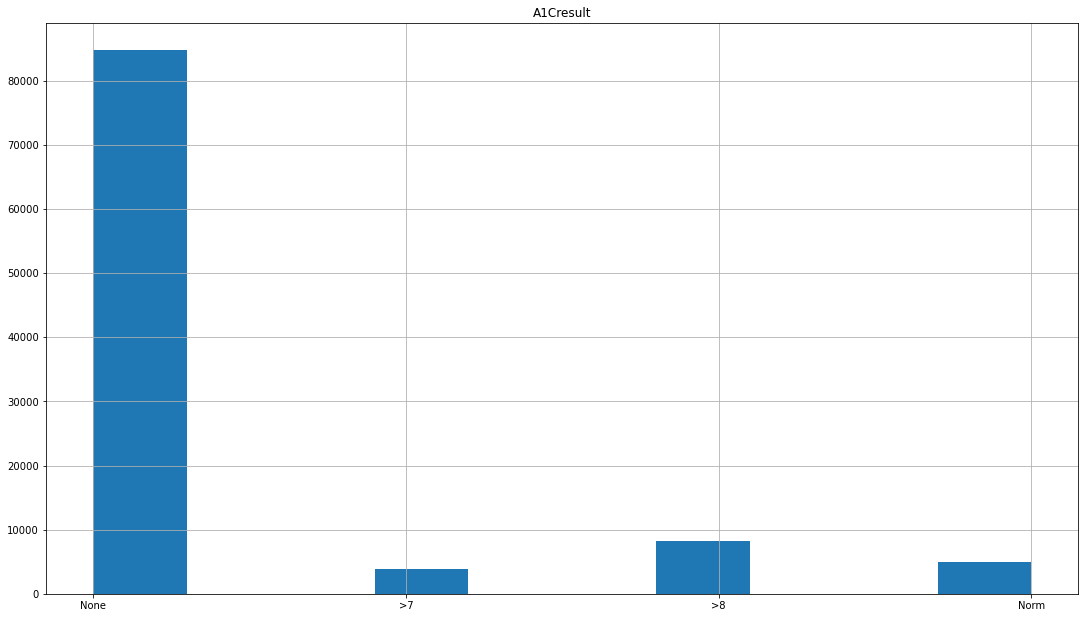

	*****
No        81778
Steady    18346
Up         1067
Down        575
Name: metformin, dtype: int64


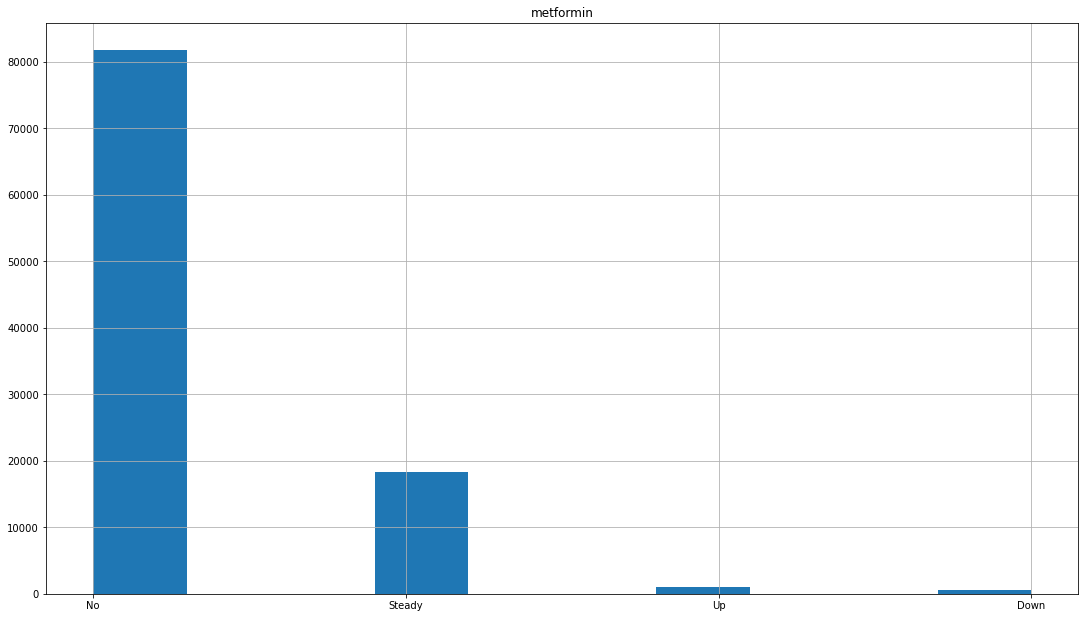

	*****
No        100227
Steady      1384
Up           110
Down          45
Name: repaglinide, dtype: int64


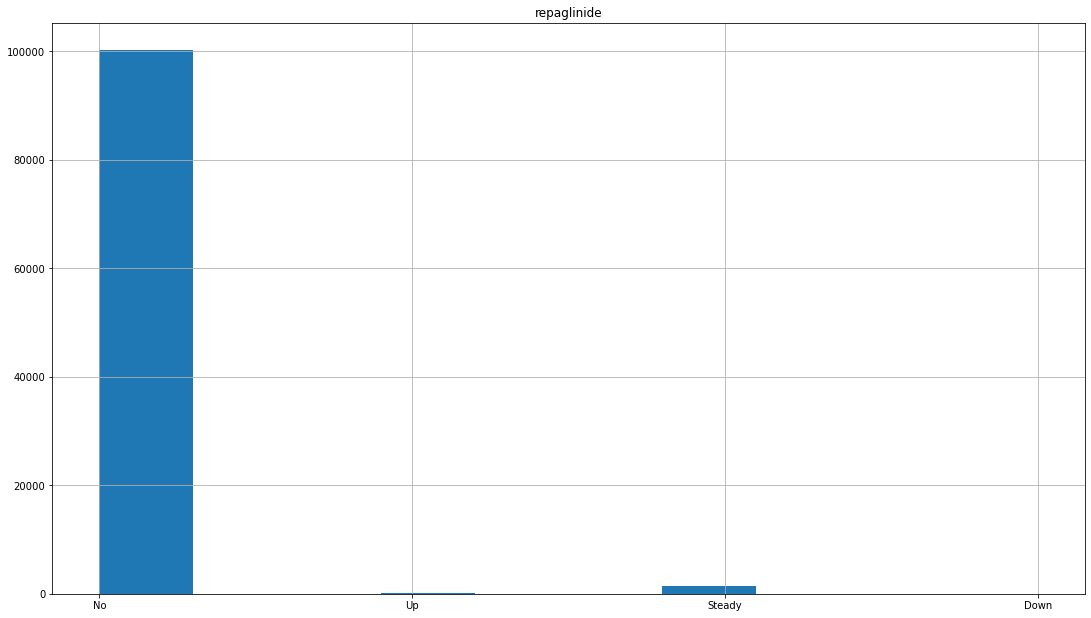

	*****
No        101063
Steady       668
Up            24
Down          11
Name: nateglinide, dtype: int64


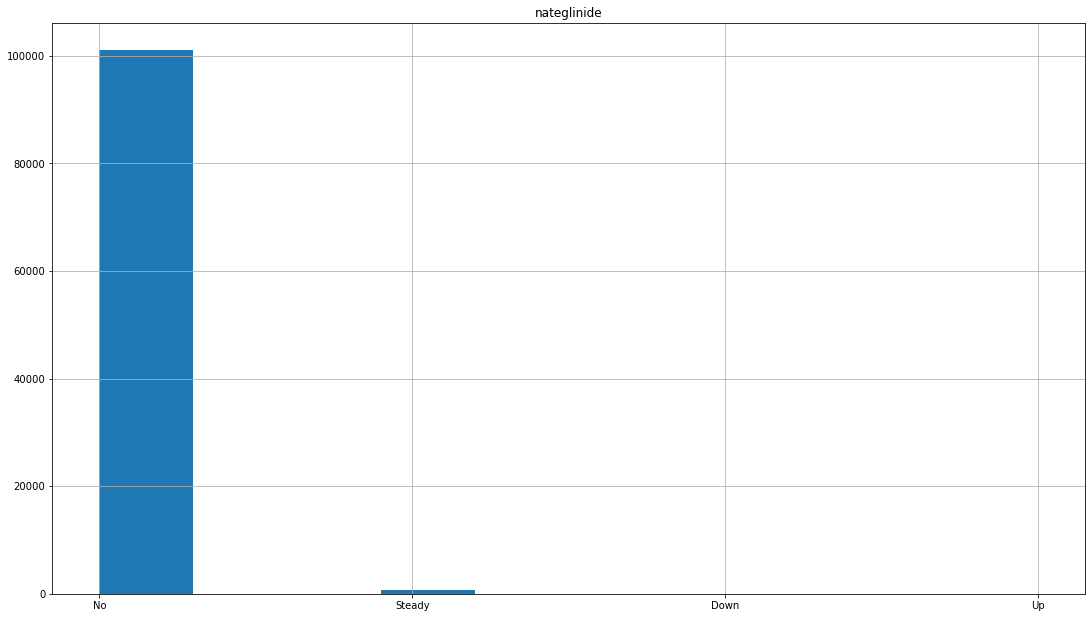

	*****
No        101680
Steady        79
Up             6
Down           1
Name: chlorpropamide, dtype: int64


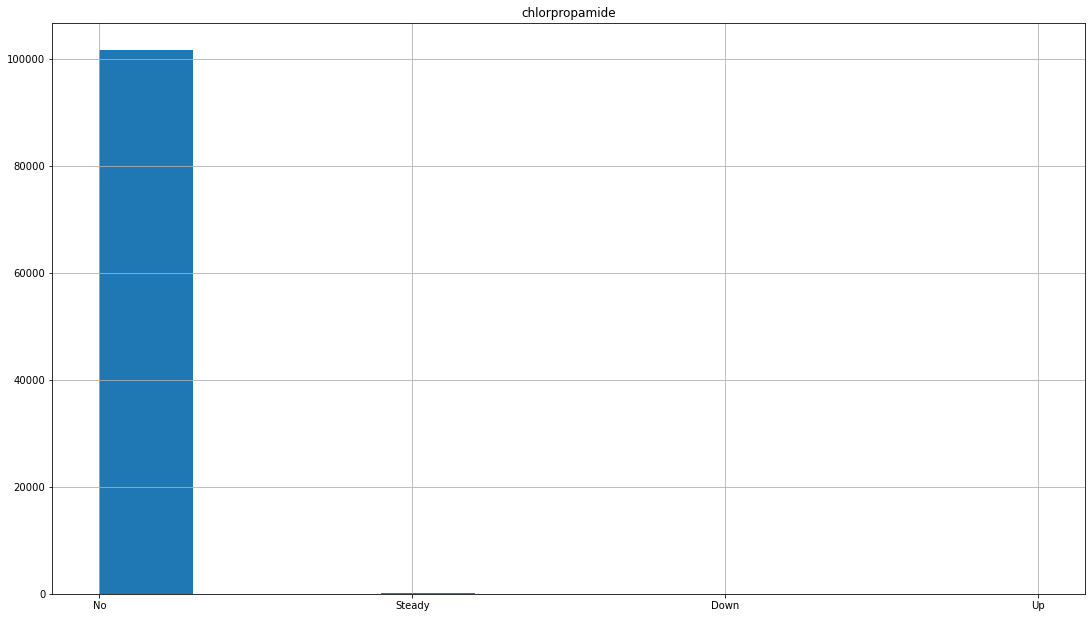

	*****
No        96575
Steady     4670
Up          327
Down        194
Name: glimepiride, dtype: int64


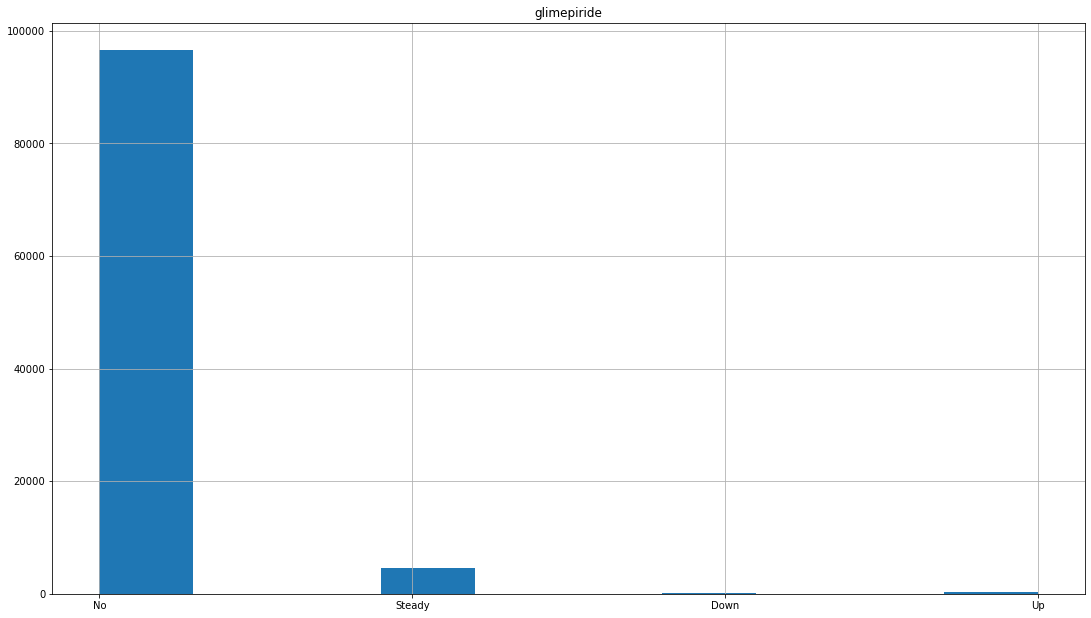

	*****
No        101765
Steady         1
Name: acetohexamide, dtype: int64


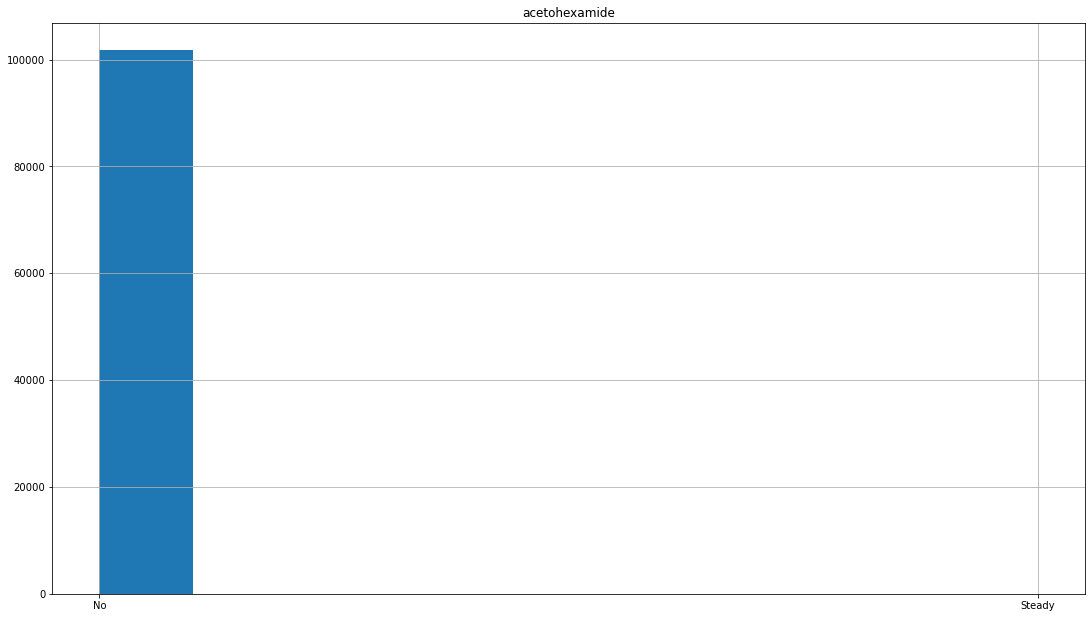

	*****
No        89080
Steady    11356
Up          770
Down        560
Name: glipizide, dtype: int64


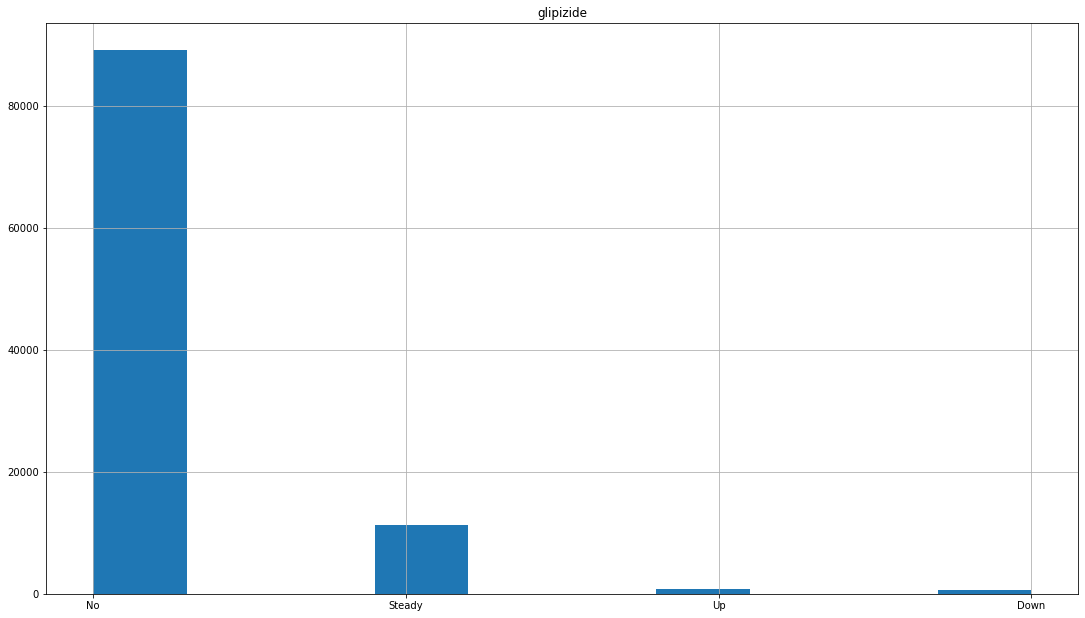

	*****
No        91116
Steady     9274
Up          812
Down        564
Name: glyburide, dtype: int64


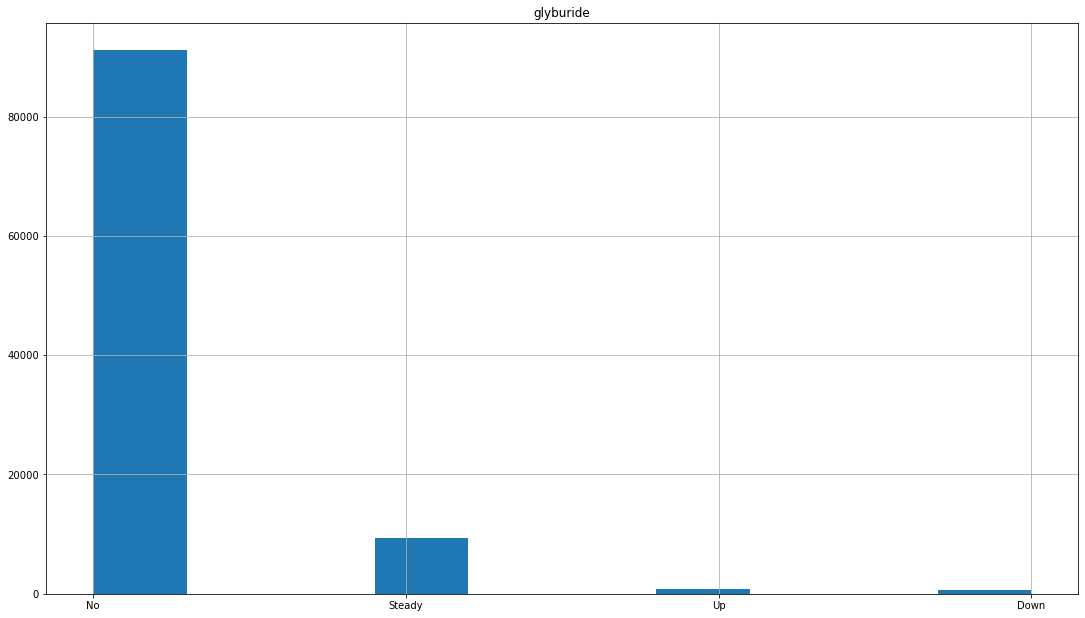

	*****
No        101743
Steady        23
Name: tolbutamide, dtype: int64


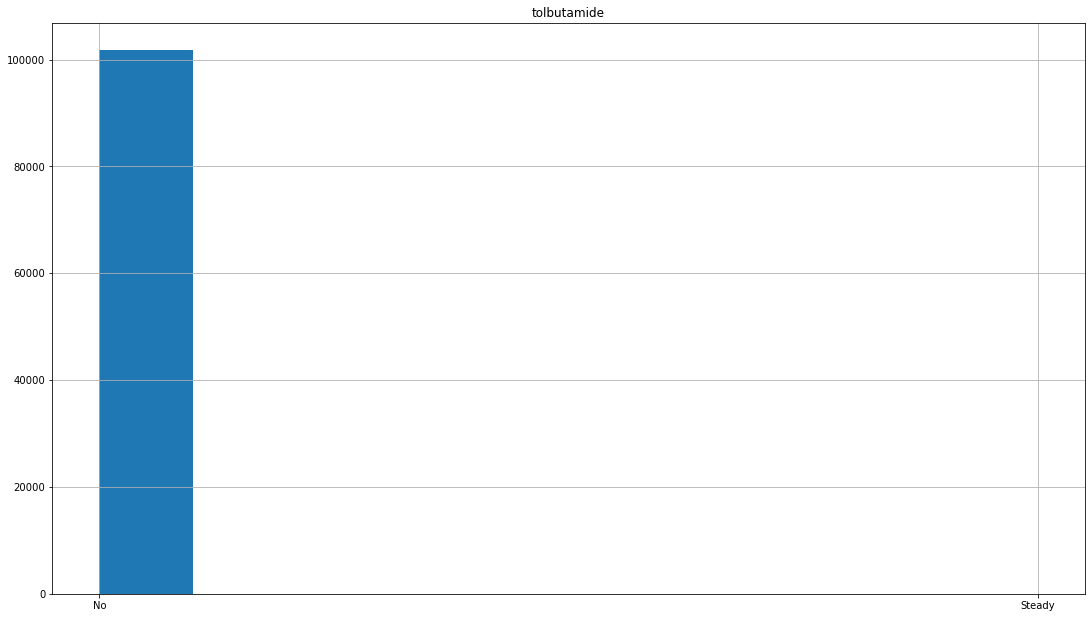

	*****
No        94438
Steady     6976
Up          234
Down        118
Name: pioglitazone, dtype: int64


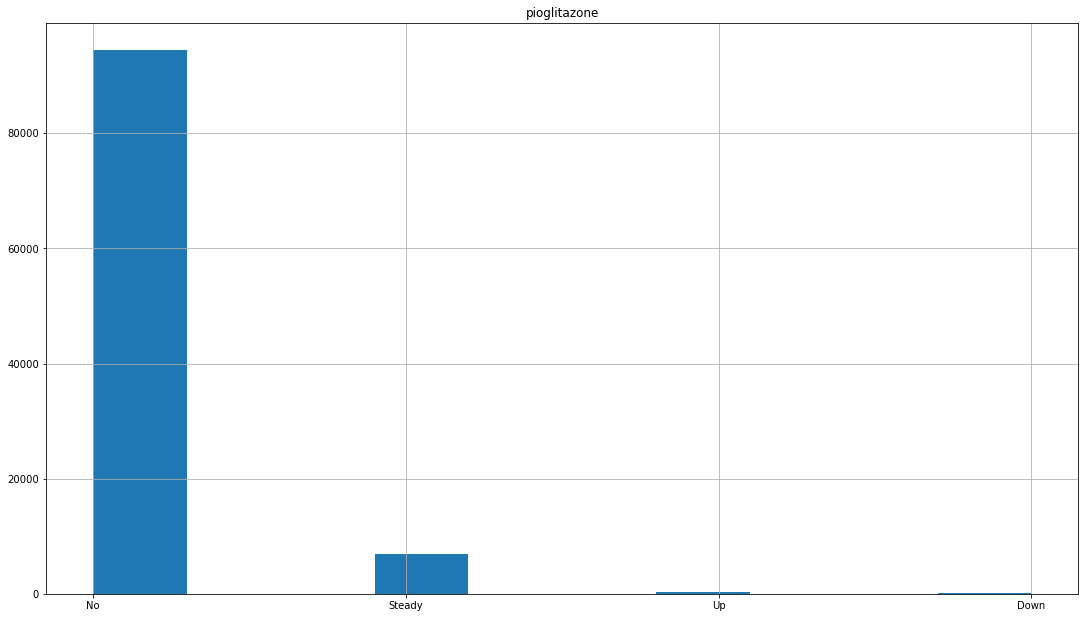

	*****
No        95401
Steady     6100
Up          178
Down         87
Name: rosiglitazone, dtype: int64


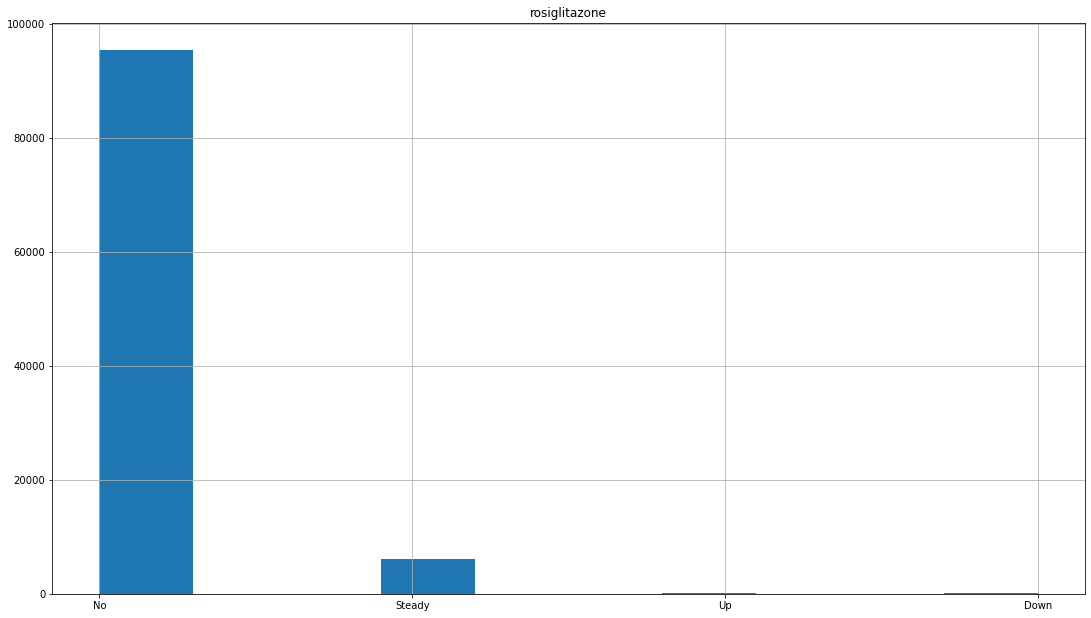

	*****
No        101458
Steady       295
Up            10
Down           3
Name: acarbose, dtype: int64


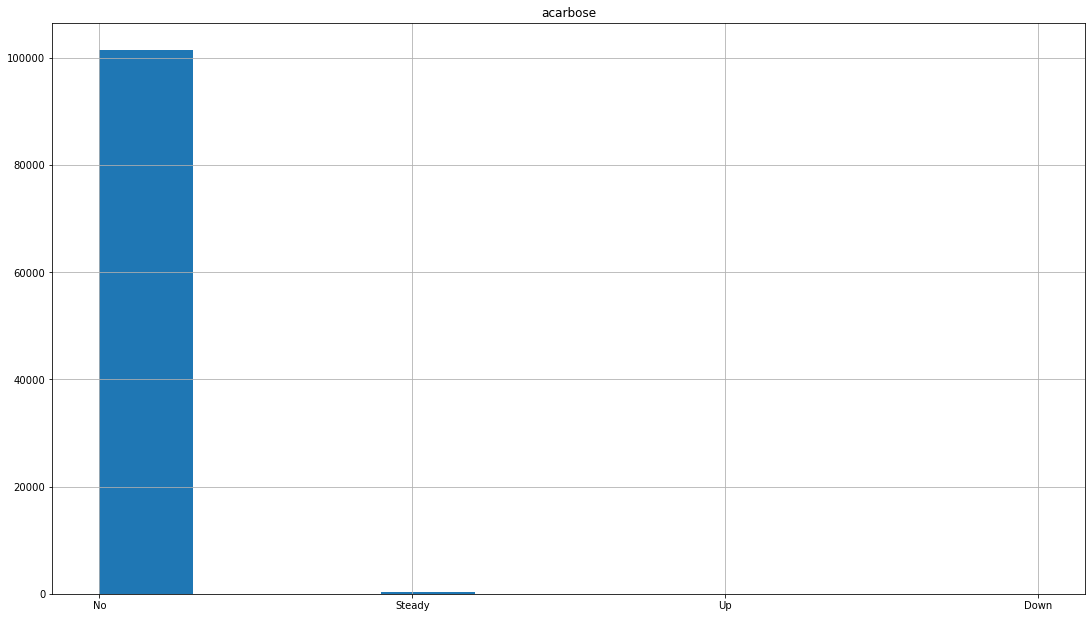

	*****
No        101728
Steady        31
Down           5
Up             2
Name: miglitol, dtype: int64


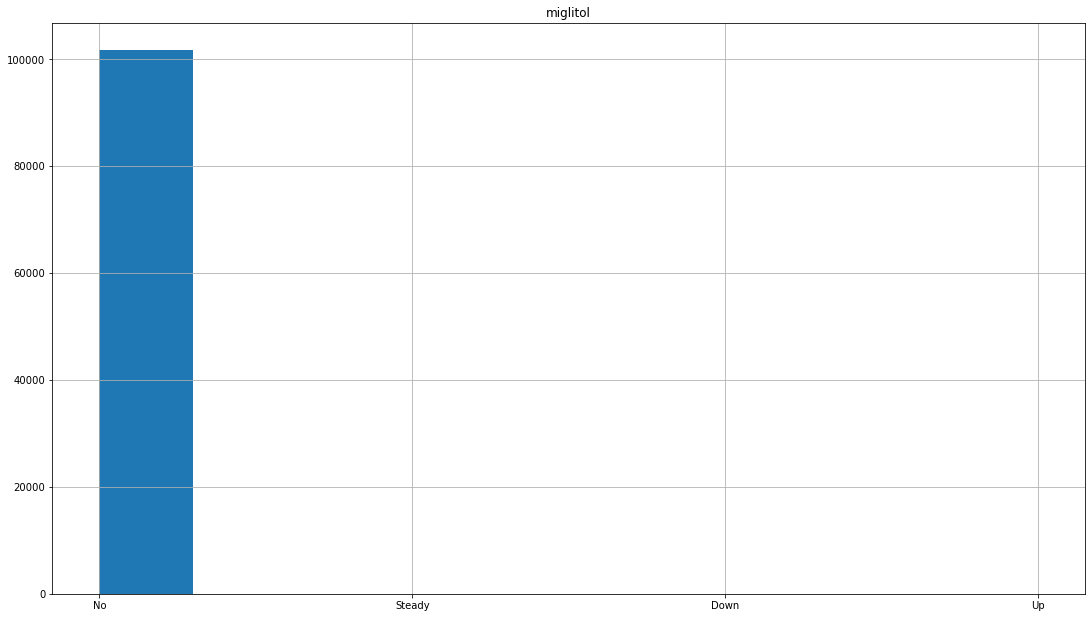

	*****
No        101763
Steady         3
Name: troglitazone, dtype: int64


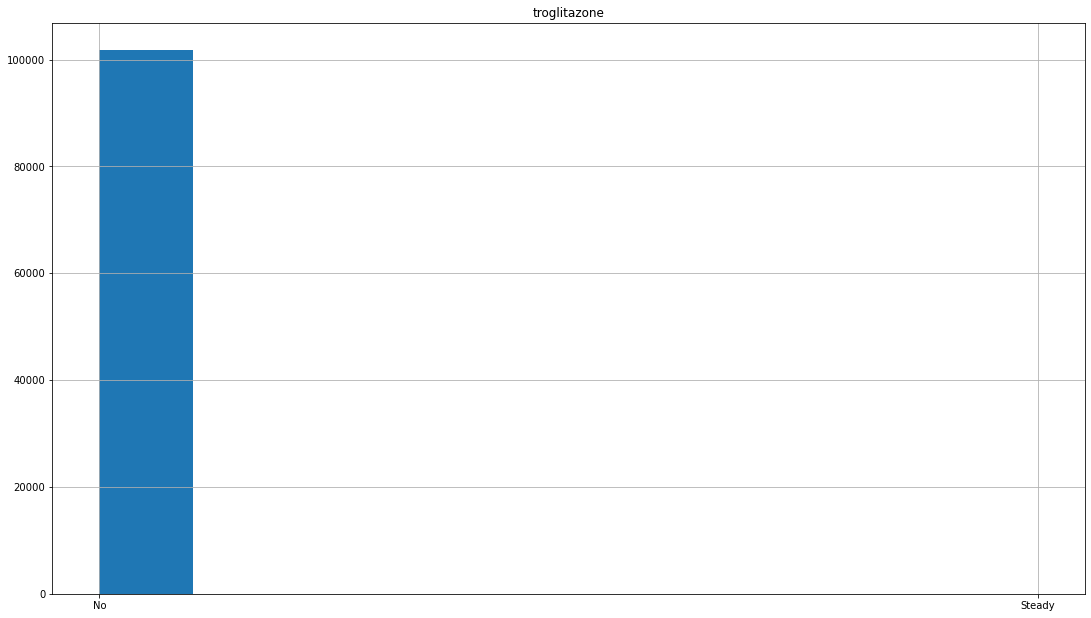

	*****
No        101727
Steady        38
Up             1
Name: tolazamide, dtype: int64


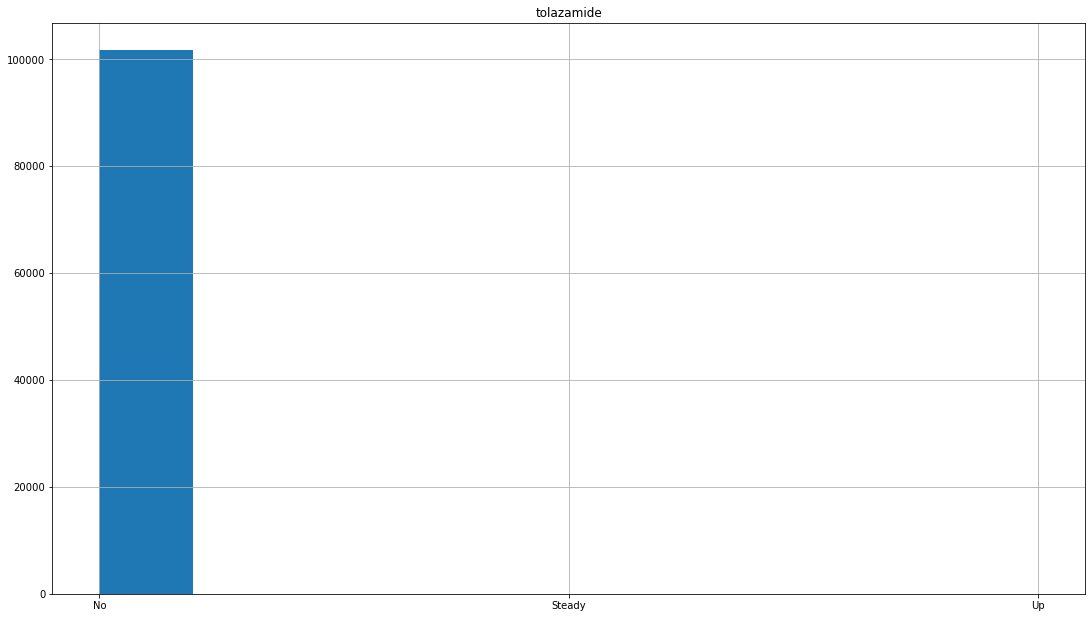

	*****
No    101766
Name: examide, dtype: int64


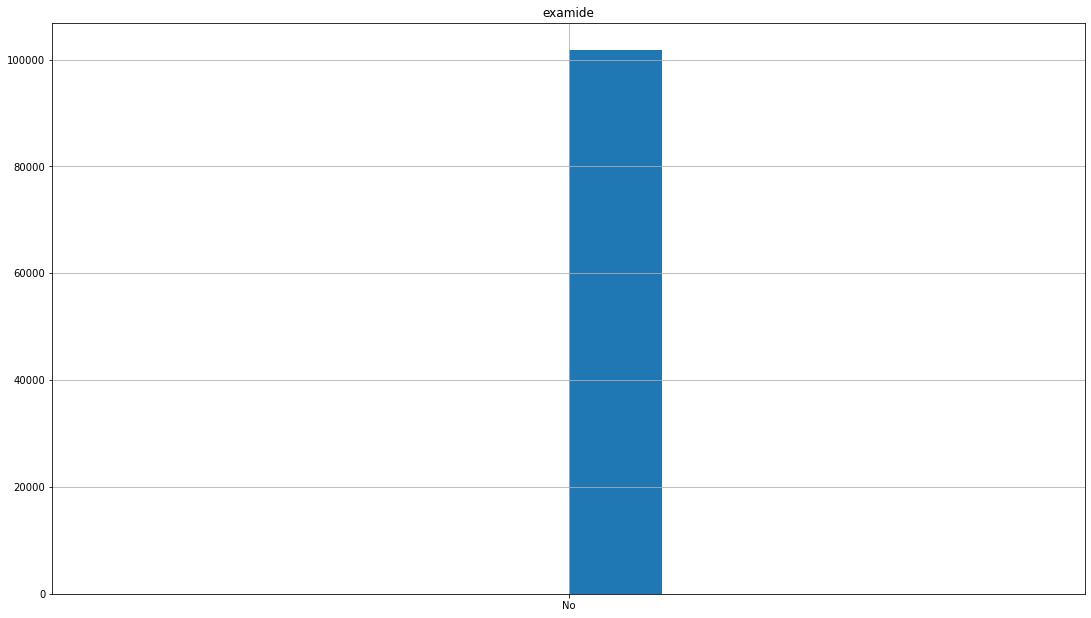

	*****
No    101766
Name: citoglipton, dtype: int64


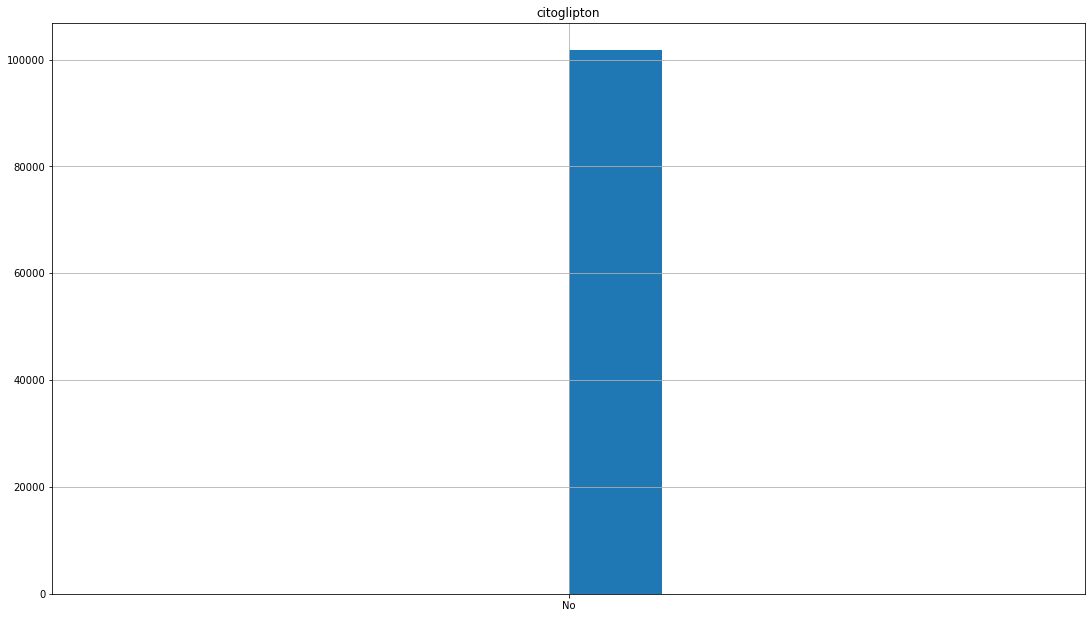

	*****
No        47383
Steady    30849
Down      12218
Up        11316
Name: insulin, dtype: int64


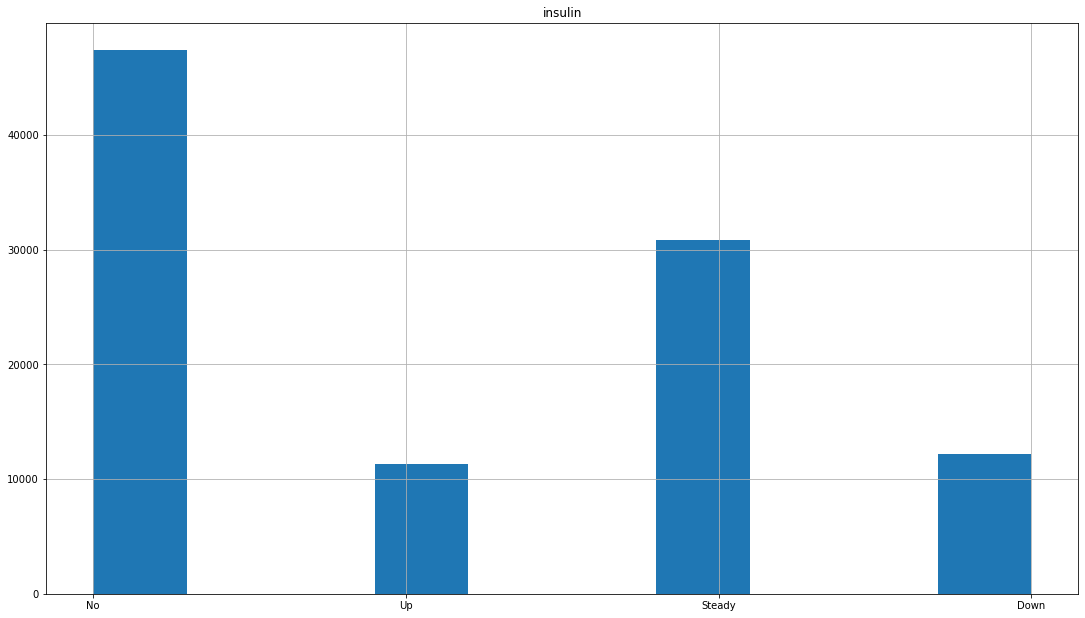

	*****
No        101060
Steady       692
Up             8
Down           6
Name: glyburide-metformin, dtype: int64


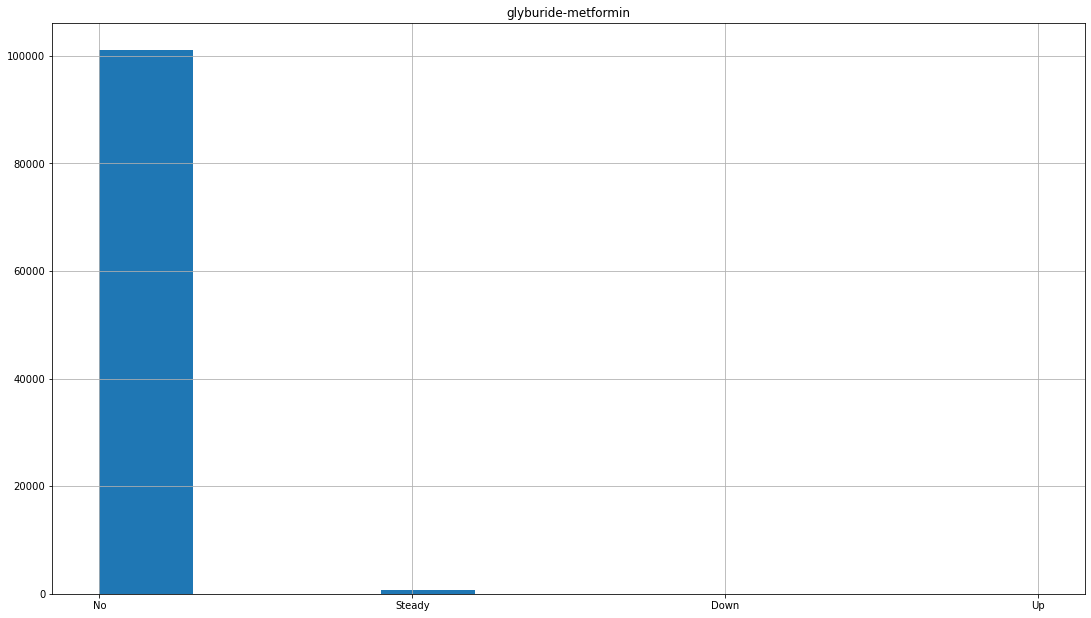

	*****
No        101753
Steady        13
Name: glipizide-metformin, dtype: int64


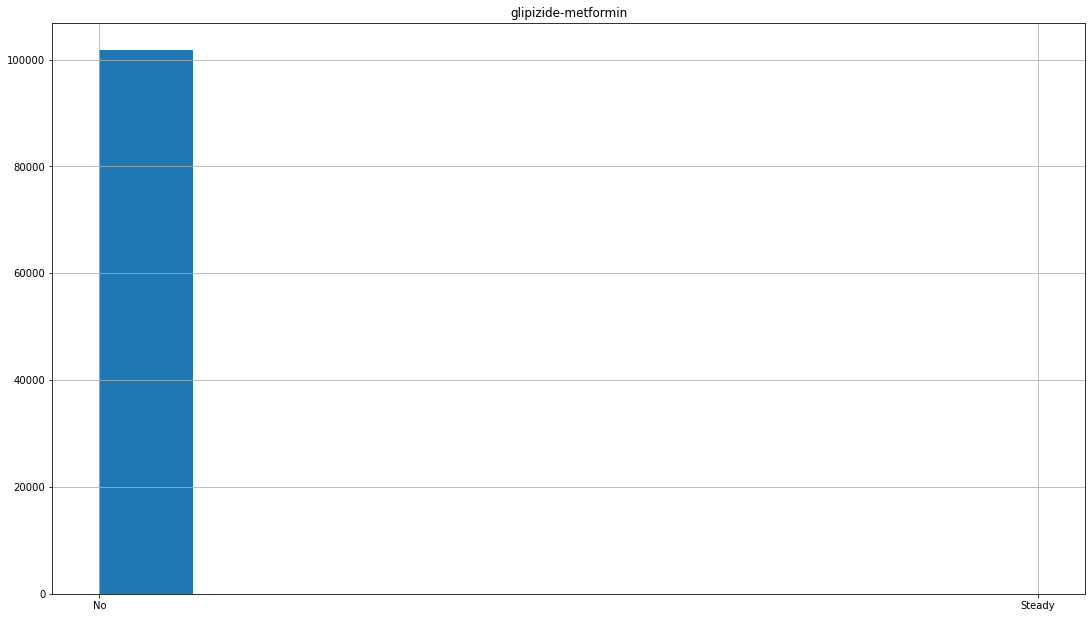

	*****
No        101765
Steady         1
Name: glimepiride-pioglitazone, dtype: int64


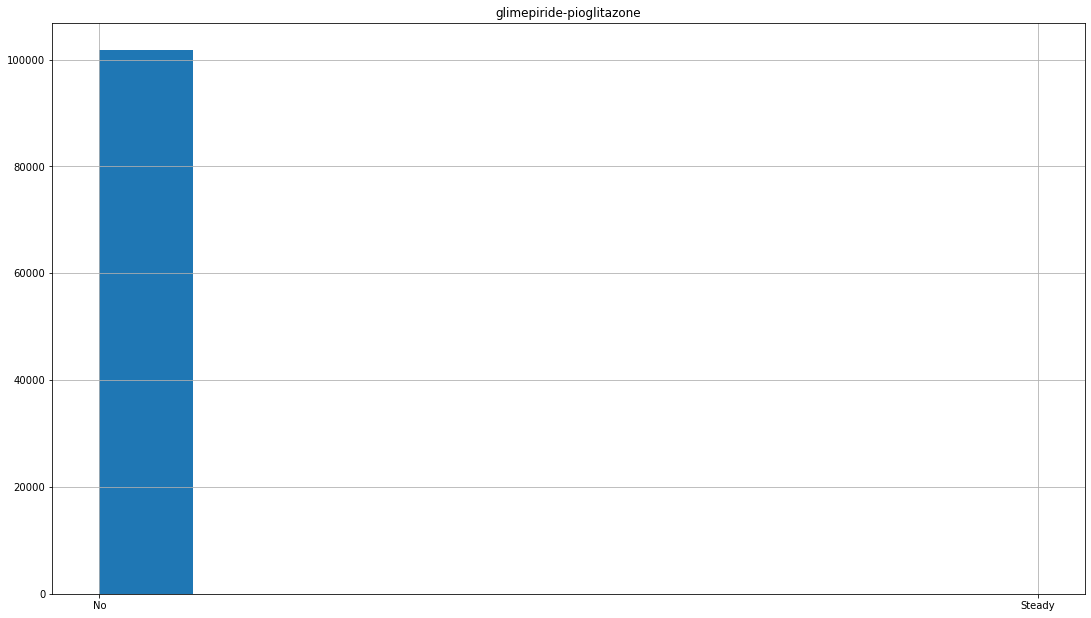

	*****
No        101764
Steady         2
Name: metformin-rosiglitazone, dtype: int64


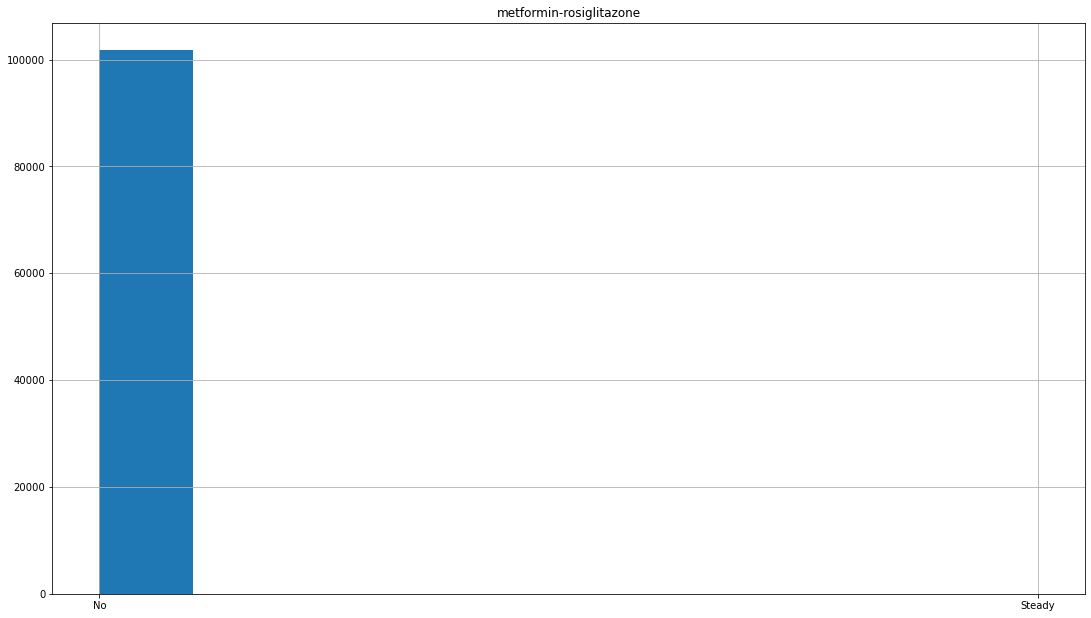

	*****
No        101765
Steady         1
Name: metformin-pioglitazone, dtype: int64


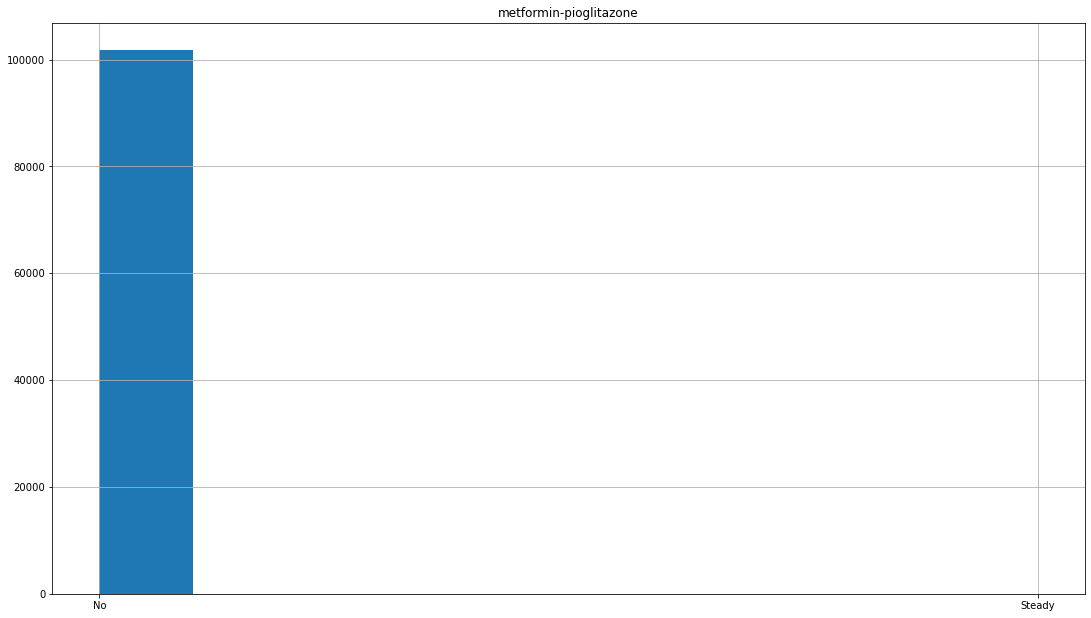

	*****
No    54755
Ch    47011
Name: change, dtype: int64


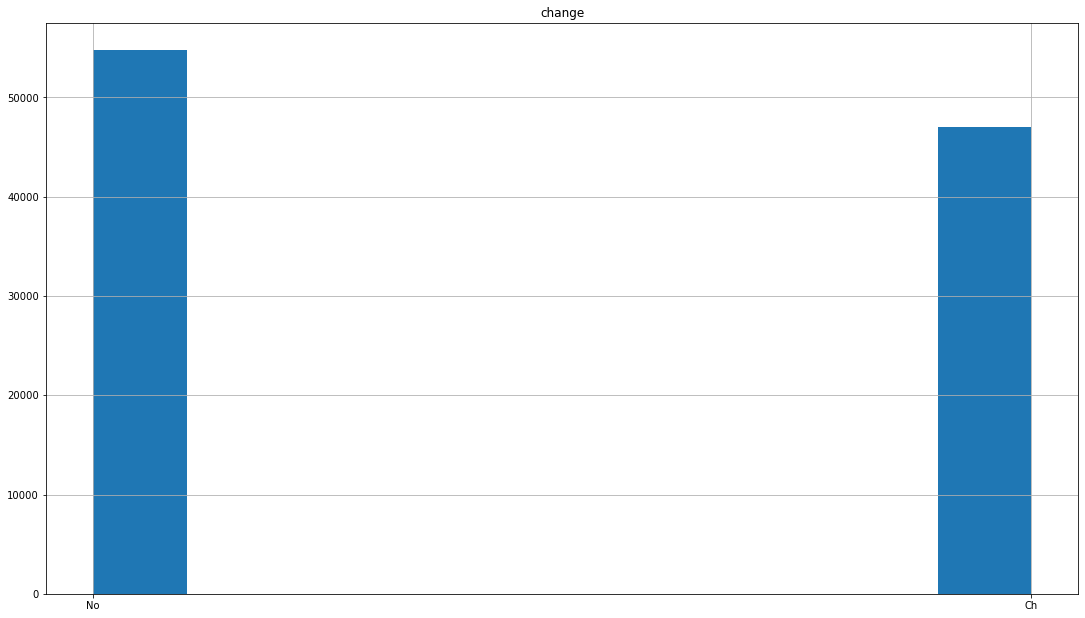

	*****
Yes    78363
No     23403
Name: diabetesMed, dtype: int64


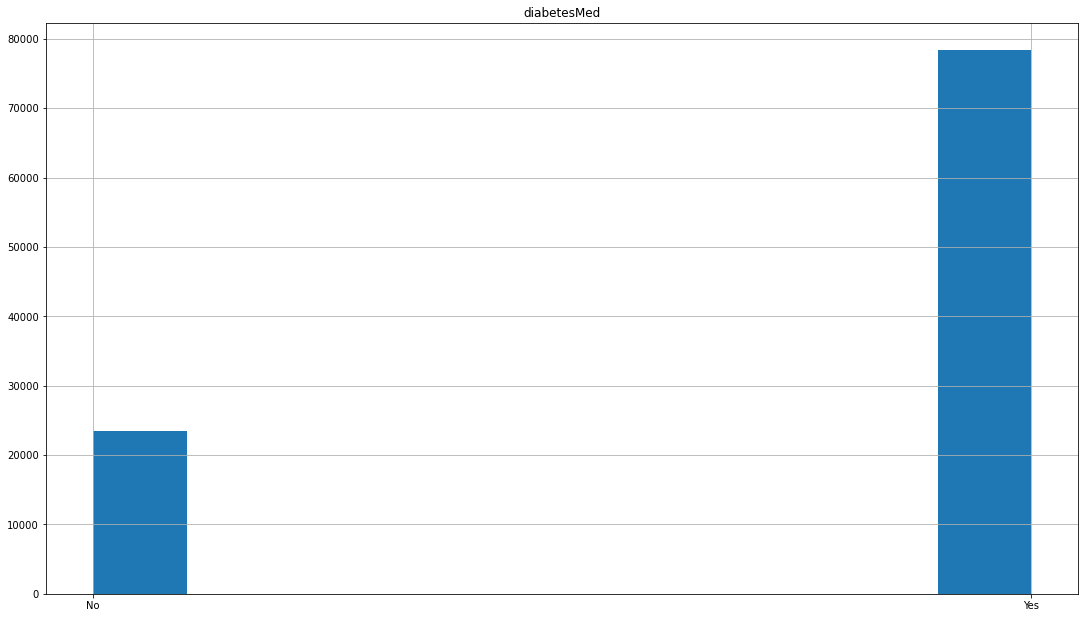

	*****
NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64


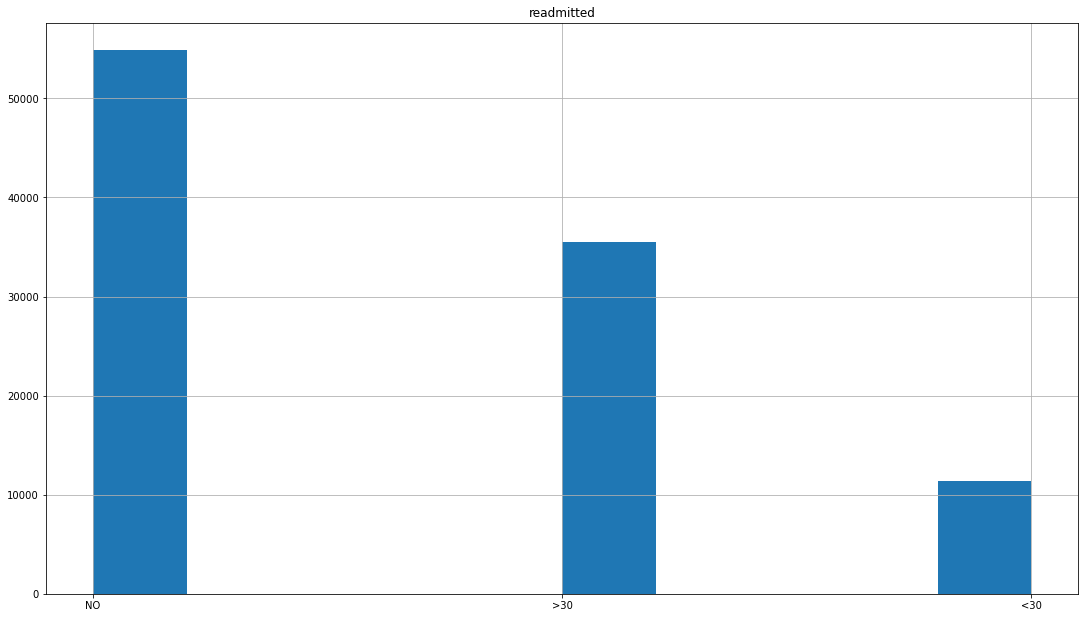

	*****
Urgent           53990
Newborn          18869
Elective         18480
Trauma Center     5291
Not Mapped          21
Not Available       10
Name: admission_type, dtype: int64


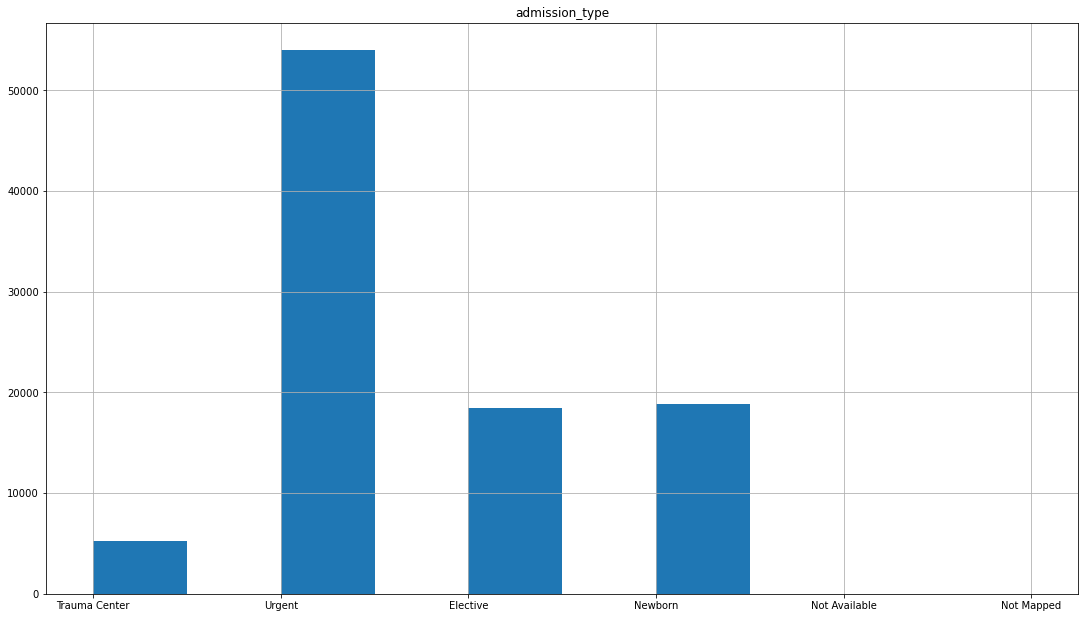

	*****


In [40]:
categorical_marked_data = diabetes_data.loc[:, diabetes_data.dtypes != int]
print('Number of categorical columns: ', categorical_marked_data.shape[1])
print('Columns with NAN values: ', 
      categorical_marked_data.columns[(categorical_marked_data.isnull().sum()>0).tolist()]
     )
print('---------Exploring Categorical Columns-----------\n\n')

for column_name in categorical_marked_data.columns:
    print(categorical_marked_data[column_name].value_counts())
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    categorical_marked_data[column_name].hist()
    plt.title(column_name)
    plt.show()
    print('\t*****')

Categorical columns exploration gave us the following:

<b>Drop Rows:</b>
1. gender: Unknown/Invalid -> 3 rows

<b>Drop Columns</b>
1. acetohexamide: It only has 2 values and only 1 row with a different value (Steady)
2. weight: ?  -> 98569 rows = 96.8% of data is missing
3. troglitazone: It only has 2 values and only 3 rows with a different value (Steady)
4. tolazamide: all columns have the same value
5. examide: all columns have the same value
6. citoglipton: all columns have the same value
7. glimepiride-pioglitazone: It only has 2 values and only 1 row with a different value 
8. metformin-rosiglitazone: It only has 2 values and only 3 rows with a different value
9. metformin-pioglitazone: It only has 2 values and only 1 row with a different value
10. tolazamide: It has only 40 rows with different values
11. tolbutamide: It has only 23 different values

In [41]:
# diabetes_data.gender = diabetes_data.gender.replace('Unknown/Invalid', np.nan)
print('Dropping missing data rows in gender')
diabetes_data = diabetes_data[diabetes_data.gender != 'Unknown/Invalid']

print("Data shape before dropping columns", diabetes_data.shape)
diabetes_data.drop(['patient_nbr', 'acetohexamide', 'weight', 'troglitazone', 
                    'tolazamide', 'examide',
                   'citoglipton', 'glimepiride', 'metformin-rosiglitazone', 
                    'metformin-pioglitazone',
                   'tolazamide', 'tolbutamide', 'encounter_id'
                   ], axis = 1, inplace = True)

print("Data shape after dropping columns", diabetes_data.shape)

Dropping missing data rows in gender
Data shape before dropping columns (101763, 50)
Data shape after dropping columns (101763, 38)


<b>Null values: (we will later try removing this column and seeing the effect)</b>
1. payer_code: ? -> 40256 rows. 40% of all data
2. medical specialty: ? -> 49949 rows, 50% of all data

## Train-Test-Validate Split
Splitting into Train-test-validate before any further analysis.

We will use the stratify feature of train test split to maintain the data set distributions of the label in test and train sets

In [42]:
# Split the dataset according to the class distribution of category_desc
y = diabetes_data["readmitted"]
x = diabetes_data[diabetes_data.columns.difference(['readmitted'])]
x_train, x_test_, y_train, y_test_ = train_test_split(x, y, 
                                                      test_size = 0.4, 
                                                      stratify=y, 
                                                      random_state=45)
x_test, x_val, y_test, y_val = train_test_split(x_test_, y_test_, 
                                                test_size = 0.5, 
                                                stratify=y_test_, 
                                                random_state=45)

print('Train shape:', x_train.shape)
print('Train data distribution:\n', y_train.value_counts())
print()
print('Test shape:', x_test.shape)
print('Test data distribution:\n', y_test.value_counts())
print()
print('Validate shape:', x_val.shape)
print('Validate data distribution:\n', y_val.value_counts())



Train shape: (61057, 37)
Train data distribution:
 NO     32916
>30    21327
<30     6814
Name: readmitted, dtype: int64

Test shape: (20353, 37)
Test data distribution:
 NO     10972
>30     7109
<30     2272
Name: readmitted, dtype: int64

Validate shape: (20353, 37)
Validate data distribution:
 NO     10973
>30     7109
<30     2271
Name: readmitted, dtype: int64


## Pre-Processing Categorical Data

All preprocessing is done only on Train data and then it is propogated to the test data.

In [43]:
categorical_marked_data = x_train.loc[:, ['race', 'gender', 'age', 'discharge_disposition_id',
       'admission_source_id', 'payer_code', 'medical_specialty', 'diag_1',
       'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'change', 'diabetesMed','admission_type']]
print(x_train.shape)
categorical_marked_data = pd.get_dummies(categorical_marked_data, 
                                         drop_first=True, 
                                         prefix=categorical_marked_data.columns.values)
pd.Series(categorical_marked_data.columns).to_csv(
                                os.path.join(OUTPUT_DATA_PATH, 'dummy_coulmns.csv')
                                                , index = False
                                                )
categorical_marked_data. drop(['admission_type_Not Available', 
                               'diag_3_?', 
                               'race_Other', 
                               'diag_2_?', 
                               'admission_type_Not Mapped'
                              ], axis = 1, inplace = True)
print(categorical_marked_data.shape)

(61057, 37)
(61057, 2270)


In [44]:
x_train = x_train[x_train.select_dtypes(
                        include=['int', 'float']
                                        ).columns.values
                 ].join(categorical_marked_data, how = 'outer')
                       
x_train.shape

(61057, 2278)

#### Numeric Columns Analysis

In [45]:
print("Numeric columns", x_train.select_dtypes(include=['int', 'float']).columns.shape[0], 
                        "- ", x_train.select_dtypes(include=['int', 'float']).columns.values)
std = x_train.select_dtypes(include=['int', 'float']).std()
median = x_train.select_dtypes(include=['int', 'float']).quantile(0.5)
# print(pd.concat(pd.DataFrame(std), median))
std_median = pd.DataFrame(std, 
                          columns = ['standard_dev']
                         ).join(pd.DataFrame(median), how = 'outer', rsuffix = 'median')
# pd.DataFrame(median)
std_median

Numeric columns 8 -  ['num_lab_procedures' 'num_medications' 'num_procedures'
 'number_diagnoses' 'number_emergency' 'number_inpatient'
 'number_outpatient' 'time_in_hospital']


,standard_dev,0.5
num_lab_procedures,19.744877,44.0
num_medications,8.140047,15.0
num_procedures,1.704044,1.0
number_diagnoses,1.932924,8.0
number_emergency,0.943338,0.0
number_inpatient,1.264316,0.0
number_outpatient,1.297679,0.0
time_in_hospital,2.978308,4.0


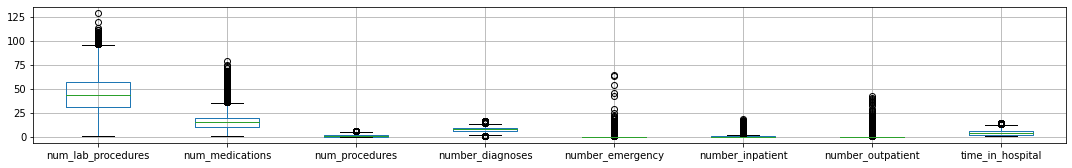

In [46]:
fig = plt.gcf()
fig.set_size_inches(18.5, 2.5)

x_train.select_dtypes(include=['int', 'float']).boxplot()

That is a lot of variance inter-intra columns. We will need to standardize the data when modelling it- based on the classification technique being used. Random forests will not need normalization. But, SVM will


<!-- 1. Changing Categorical to numerical
This will also require handling missing values  -->

## Correlations 

In [ ]:
columns_pairplot = x_train.select_dtypes(include=['int', 'float']).join(y_train)
sns.pairplot(columns_pairplot, hue = 'readmitted')
plt.show()

So, readmission does not show any great trends on a pairwise analysis of these metrics . We will see below that the spread of the data in all classes is very similar. Hence, the overlap of points. I actually had to subset for every y value to confirm the majority "green" color is becuase of overlap, becauase we know that 50% of the data shows no readmissions. '>30' is 35%; and '<30' is 15%
So, most green showing in the above chart has nothing to do with the y label distribution

In [ ]:
fig = plt.gcf()
y_types = list(set(y_train.values))

fig, axs = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(18.5, 10.5)

for i in range(3):
    plot = columns_pairplot.loc[columns_pairplot.readmitted==y_types[i],:].boxplot(ax=axs[i])

In [ ]:
# Compute the correlation matrix
corr = columns_pairplot.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Interestingly, this data does not have any outright correlations in the numerical columns. If there were any |correlation| >= 0.9 I would have wanted to drop that feature. 

## Standardizing the Data

Let us only normalize the features that were originally int/float. Not the categorical features we one hot-encoded

I did not apply log normalization even though we care about the relative changes in the columns because  my data has 0s.  The domain for log is strictly greater than 0. That’s a vertical asymptote heading down the y-axis. As x approaches 0, y approaches negative infinity. In other words, 0 is excluded from the domain.

But, I can add 1 to all my data and then take a log transform. This also maintains my spread. Cool right!


/Users/gaurikatyagi/opt/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared


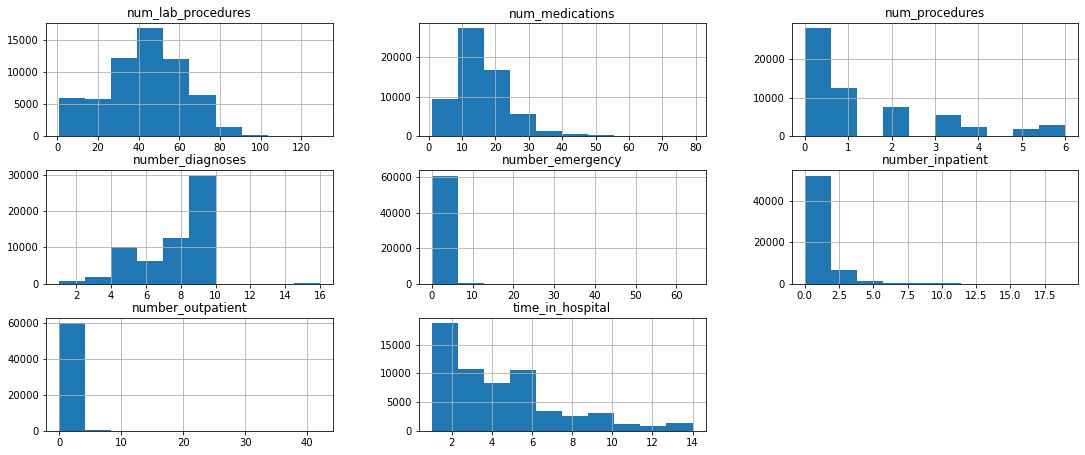

/Users/gaurikatyagi/opt/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared


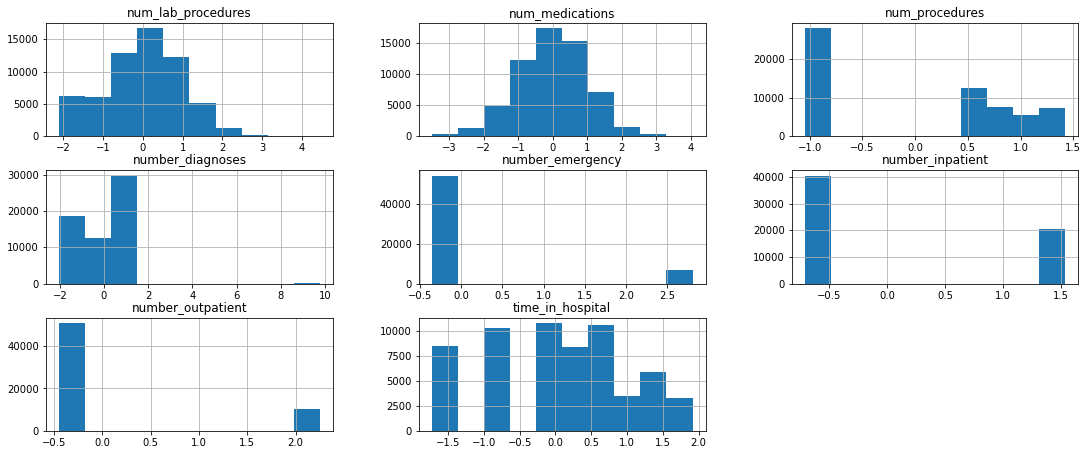

num_lab_procedures    1.000008
num_medications       1.000008
num_procedures        1.000008
number_diagnoses      1.000008
number_emergency      1.000008
number_inpatient      1.000008
number_outpatient     1.000008
time_in_hospital      1.000008
dtype: float64
num_lab_procedures    1.000016
num_medications       1.000016
num_procedures        1.000016
number_diagnoses      1.000016
number_emergency      1.000016
number_inpatient      1.000016
number_outpatient     1.000016
time_in_hospital      1.000016
dtype: float64


In [47]:
from sklearn.preprocessing import PowerTransformer
standardizer = PowerTransformer()



from sklearn.preprocessing import StandardScaler
normalizer = StandardScaler()

standardizer.fit(x_train.select_dtypes(include=['int', 'float'])+1)
transformed_interim = standardizer.transform(x_train.select_dtypes(include=['int','float']))
# transformed = pd.DataFrame(transformed_interim, 
#                            columns =  x_train.select_dtypes(include=['int','float']).columns)
normalizer.fit(transformed_interim)
transformed = pd.DataFrame( normalizer.transform(transformed_interim), 
                           columns =  x_train.select_dtypes(include=['int','float']).columns)

# Plot the data before and after the transformation
fig = plt.figure(figsize = (18.5, 7.5))
ax = fig.gca()

x_train.select_dtypes(include=['int','float']).hist(ax=ax)
plt.show()

fig = plt.figure(figsize = (18.5, 7.5))
ax = fig.gca()
transformed.hist(ax=ax)
plt.show()

# fig = plt.gcf()
# fig.set_size_inches(18.5, 2.5)
# transformed.boxplot()
# plt.ylim(0, 20)
print(transformed.std())
print(transformed.var())

In [48]:
# from scipy import boxcox 

##confirming that no NANs were generated because of the transformation
is_NaN = transformed.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = transformed[row_has_NaN]

print(rows_with_NaN)


Empty DataFrame
Columns: [num_lab_procedures, num_medications, num_procedures, number_diagnoses, number_emergency, number_inpatient, number_outpatient, time_in_hospital]
Index: []


In [49]:
# print(transformed.shape)
# transformed.head()

In [50]:
x_train.reset_index(inplace= True, drop= True)
x_train.loc[:, transformed.columns] = transformed
print(x_train.shape)
# x_train.head()

(61057, 2278)


In [51]:
is_NaN = x_train.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = x_train[row_has_NaN]

print("Number of empty rows: ", rows_with_NaN.shape)

Number of empty rows:  (0, 2278)


## Feature Selection
Apply PCA to reduce features

In [52]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train)


PCA()

In [53]:
# Look at the percentage of variance explained by the different components
variance_explained = (pd.DataFrame([x_train.columns.values, pca.explained_variance_ratio_]
                                  ).transpose().rename(columns = {0:'columns', 1:'variance'}) 
                     ).sort_values('variance', ascending = False)
print(variance_explained.head(5))

              columns   variance
0  num_lab_procedures   0.124246
1     num_medications  0.0841264
2      num_procedures  0.0690355
3    number_diagnoses  0.0519441
4    number_emergency  0.0492411


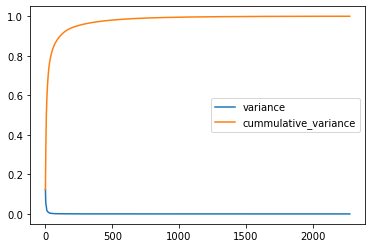

In [54]:
variance_explained['cummulative_variance']= variance_explained.variance.cumsum()
variance_explained.plot()

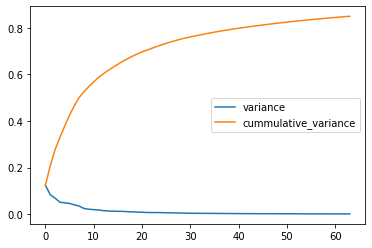

In [55]:
variance_explained.loc[variance_explained.cummulative_variance<0.85, :].plot()

In [56]:
print(variance_explained.loc[variance_explained.cummulative_variance<0.85, :].shape[0], 
      "Features explain 85% of the variance. Sounds like a reasonable trade off to drop",
      x_train.shape[1]-variance_explained.loc[
                                      variance_explained.cummulative_variance<0.85, :
                                              ].shape[0], 
      "columns for 15% variance. Let's check" )

64 Features explain 85% of the variance. Sounds like a reasonable trade off to drop 2214 columns for 15% variance. Let's check


In [57]:
select_columns = variance_explained.loc[variance_explained.cummulative_variance<0.85, :
                                       ]["columns"].values
print("Before column selection:", x_train.shape)
x_train.drop(x_train.columns.difference(select_columns), 1, inplace=True)
print("After column selection:", x_train.shape)

Before column selection: (61057, 2278)
After column selection: (61057, 64)


#### T-SNE

We use t-SNE to visualize high dimensional Data

•	It will maximize the distance in 2 dimensional space in observations that are most different in the high dimensional space. This is why observations close together will get clustered

•	It does not work for non-numeric data

•	t-SNE is super powerful, but do you know exactly when to use it:

    o	When you want to visually explore the patterns in a high dimensional dataset.


In [61]:
from sklearn.manifold import TSNE
tsne_model = TSNE(learning_rate = 200)
tsne_features = tsne_model.fit_transform(x_train)
print(tsne_features.shape)

(61057, 2)


In [62]:
# tsne_features[y_train== 'NO', 0].shape
# tsne_features.shape

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


['>30', '<30', 'NO']
[0.115, 0.7025, 0.6775]


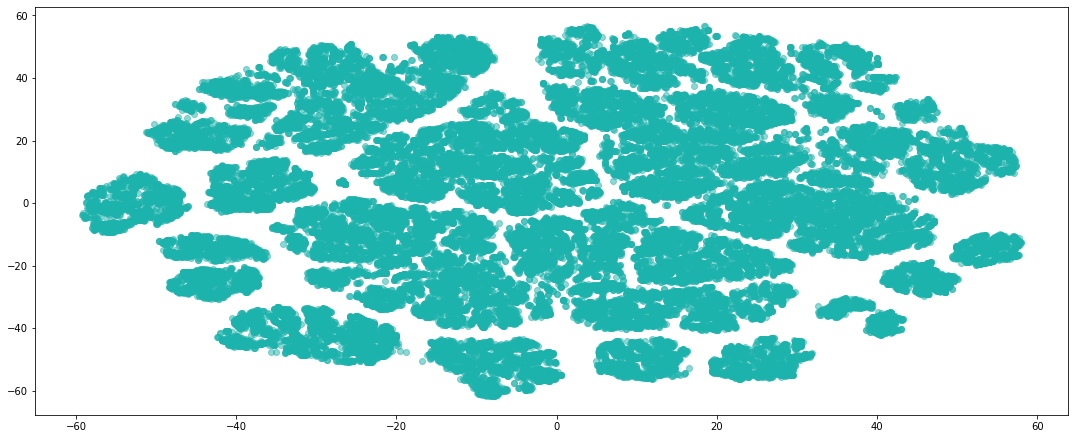

In [63]:
fig = plt.figure(figsize = (18.5, 7.5))
ax = fig.gca()
names = list(set(y_train))
print(names)
colors = [float(hash(s) % 300) / 400 for s in names]
print(colors)
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], alpha = 0.5,  c= colors, cmap= "jet")
# plt.scatter(tsne_features[y_train== 'NO', 0], tsne_features[y_train== 'NO', 1])
# # Annotate the points
# for x, y, readmission in zip(tsne_features[:, 0], tsne_features[:, 1], y_train):
#     plt.annotate(readmission, (x, y), fontsize=5, alpha=0.75)

plt.show()


In [64]:
# reduce dimensionality with t-sne
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=50)
tsne_results = tsne.fit_transform(x_train)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 61057 samples in 2.248s...
[t-SNE] Computed neighbors for 61057 samples in 230.134s...
[t-SNE] Computed conditional probabilities for sample 1000 / 61057
[t-SNE] Computed conditional probabilities for sample 2000 / 61057
[t-SNE] Computed conditional probabilities for sample 3000 / 61057
[t-SNE] Computed conditional probabilities for sample 4000 / 61057
[t-SNE] Computed conditional probabilities for sample 5000 / 61057
[t-SNE] Computed conditional probabilities for sample 6000 / 61057
[t-SNE] Computed conditional probabilities for sample 7000 / 61057
[t-SNE] Computed conditional probabilities for sample 8000 / 61057
[t-SNE] Computed conditional probabilities for sample 9000 / 61057
[t-SNE] Computed conditional probabilities for sample 10000 / 61057
[t-SNE] Computed conditional probabilities for sample 11000 / 61057
[t-SNE] Computed conditional probabilities for sample 12000 / 61057
[t-SNE] Computed conditional probabilities for 

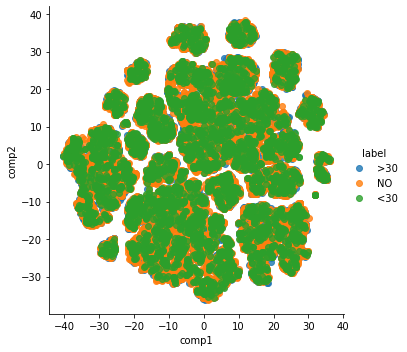

In [65]:
# visualize

df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = y_train
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)


### Standardizing Test and Validate data 

In [58]:
categorical_marked_data_ = x_test.loc[:, ['race', 'gender', 'age', 'discharge_disposition_id',
       'admission_source_id', 'payer_code', 'medical_specialty', 'diag_1',
       'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'change', 'diabetesMed','admission_type']]
print(x_test.shape)
categorical_marked_data_ = pd.get_dummies(categorical_marked_data_, 
                                         drop_first=True, 
                                         prefix=categorical_marked_data_.columns.values)
x_test = x_test[x_test.select_dtypes(
                        include=['int', 'float']
                                        ).columns.values
                 ].join(categorical_marked_data_, how = 'outer')
                       
x_test = x_test.reindex(columns = x_train.columns, fill_value=0)
print(x_test.shape)
# test_preprocessed = dataset_preprocessed[train_objs_num:]

(20353, 37)
(20353, 64)


## Classification

In [59]:
from sklearn.metrics import confusion_matrix, auc, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

def confusion_matrix_display(y_true, y_pred, labels, ymap=None, figsize=(10, 10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap = "Greens")
    plt.show()

def analyze_model(model_, x_train, y_train, x_test, y_test):
    """
    Generate model validation metrics
    args: 
      model_:    classification model being analyzed
      x_train:   features of training sample
      y_train:   labels of training sample
      x_test:    features of test set
      y_test:    true label of the data, with shape (nsamples,)
    """
    print("Train Score:", model_.score(x_train, y_train))
    print("Test Score:", model_.score(x_test, y_test))
    y_pred = model_.predict(x_test)
    labels = model_.classes_
    print("F1 Score: ", f1_score(y_test, y_pred, average="macro"))
    print("Precision Score: ", precision_score(y_test, y_pred, average="macro"))
    print("Recall Score: ", recall_score(y_test, y_pred, average="macro")) 

    cm = confusion_matrix(y_test, y_pred, labels = labels)
    print("Confusion Matrix:\n", cm)
    confusion_matrix_display(y_test, y_pred, labels, ymap=None, figsize=(5,5))


#     ax= plt.subplot()
#     sns.heatmap(cm, annot=True, ax = ax, cmap="Greens", fmt='g')

#     # labels, title and ticks
#     ax.set_xlabel('Predicted labels')
#     ax.set_ylabel('True labels')
#     ax.set_title('Confusion Matrix')
#     ax.xaxis.set_ticklabels(labels)
#     ax.yaxis.set_ticklabels(labels)
#     plt.show()



### SVC

In [60]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc_model = SVC() ## default kernel - RBF
parameters = {'C':[0.1, 1, 10], 'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svc_model, param_grid = parameters, n_jobs= 4, verbose = 2, return_train_score= True)
searcher.fit(x_train, y_train)
# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 75.0min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 202.8min finished


Best CV params {'C': 1, 'gamma': 0.1}
Best CV accuracy 0.581505821739126


Train Score: 0.5997838085723177
Test Score: 0.5386429518989829
F1 Score:  0.23365342738173486
Precision Score:  0.24213973709658912


/Users/gaurikatyagi/opt/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall Score:  0.3331094357481708
Confusion Matrix:
 [[    0     1  2271]
 [    0     3  7106]
 [    0    12 10960]]


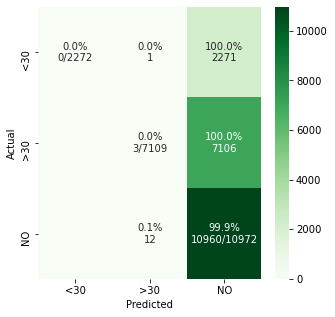

In [66]:
analyze_model(searcher, x_train, y_train, x_test, y_test)

### KNN

Train Score: 0.7195735132744813
Test Score: 0.5170245172701813
F1 Score:  0.31756116378631327
Precision Score:  0.37375006039461484
Recall Score:  0.3511425692115142
Confusion Matrix:
 [[ 151  298 1823]
 [ 290  841 5978]
 [ 312 1129 9531]]


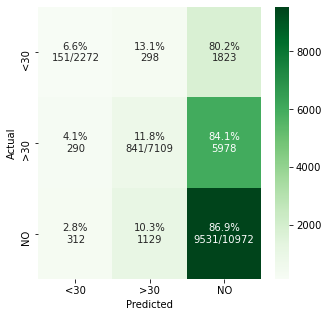

In [67]:
from sklearn.neighbors import KNeighborsClassifier
knn= KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)

analyze_model(knn, x_train, y_train, x_test, y_test)

### Random Forests

Train Score: 0.9780532944625514
Test Score: 0.5495013020193583
F1 Score:  0.3884783625259726
Precision Score:  0.42297624043648624
Recall Score:  0.3958617172604057
Confusion Matrix:
 [[ 160  783 1329]
 [ 320 2270 4519]
 [ 259 1959 8754]]


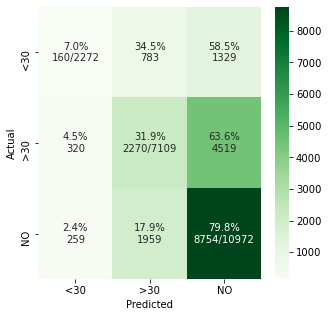

In [68]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 200
                             , min_samples_split= 4
                             , n_jobs = 4
#                              , verbose =1
                            )
rfc.fit(x_train, y_train)
analyze_model(rfc, x_train, y_train, x_test, y_test)

#### Cross Validated RandomFrorest

In [69]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

mse = make_scorer(mean_squared_error)

# Set up cross_val_score
cv = cross_val_score(estimator=rfc,
                     X=x_train,
                     y=y_train.str.get_dummies(), 
                     cv=10,
                     scoring=mse)

# Print the mean error
print(cv.mean())

0.27973313843277814


### Logistic Regression

Train Score: 0.5774440277118102
Test Score: 0.3684469120031445
F1 Score:  0.21642581181752765
Precision Score:  0.5428739051138041
Recall Score:  0.35215289464881794
Confusion Matrix:
 [[   70  2201     1]
 [   64  7038     7]
 [  106 10475   391]]


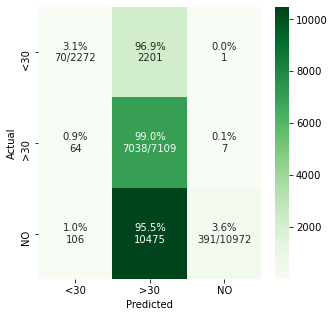

In [70]:
from sklearn.linear_model import LogisticRegressionCV

lr_cv = LogisticRegressionCV(cv=15, random_state=45, max_iter=1500).fit(x_train, y_train)
analyze_model(lr_cv, x_train, y_train, x_test, y_test)

### Naive Bayes

Train Score: 0.5774440277118102
Test Score: 0.3684469120031445
F1 Score:  0.21642581181752765
Precision Score:  0.5428739051138041
Recall Score:  0.35215289464881794
Confusion Matrix:
 [[   70  2201     1]
 [   64  7038     7]
 [  106 10475   391]]


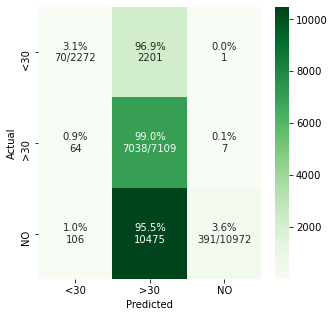

In [71]:
from sklearn.naive_bayes import GaussianNB
# # Fit nb to the training sets
gnb = GaussianNB().fit( x_train, y_train)
analyze_model(lr_cv, x_train, y_train, x_test, y_test)



In [72]:
prediction_probs = pd.DataFrame(gnb.predict_proba(x_test), columns = gnb.classes_).round(2)
prediction_probs["actual"] =y_test.reset_index(drop=True)
prediction_probs


,<30,>30,NO,actual
0,0.00,0.02,0.98,NO
1,0.01,0.99,0.00,NO
2,0.00,1.00,0.00,NO
3,0.00,1.00,0.00,>30
4,0.00,1.00,0.00,NO
...,...,...,...,...
20348,0.00,1.00,0.00,>30
20349,0.00,0.11,0.89,NO
20350,0.00,0.00,1.00,NO
20351,0.00,0.00,1.00,NO


ghosh, this is too much to find the ideal model. What do we do? 

## GridSearch

In [73]:
import hyperopt as hyp
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Set up space dictionary with specified hyperparameters
space = {'max_depth': hyp.hp.quniform('max_depth', 2, 10, 2),
         'learning_rate': hyp.hp.uniform('learning_rate', 0.001,0.9)
        }

# Set up objective function
def objective(params):
    params = {'max_depth': int(params['max_depth']),'learning_rate': params['learning_rate']}
    gbm_clf = GradientBoostingClassifier(n_estimators=100, **params) 
    best_score = cross_val_score(gbm_clf, x_train, y_train, scoring='accuracy', cv=2, n_jobs=4).mean()
    loss = 1 - best_score
    return loss

# Run the algorithm
best = hyp.fmin(fn=objective,space=space, max_evals=20, rstate=np.random.RandomState(42), algo=hyp.tpe.suggest)
print(best)

100%|██████████| 20/20 [10:20<00:00, 31.04s/trial, best loss: 0.41978807692592945]
{'learning_rate': 0.11310589268581149, 'max_depth': 6.0}


In [74]:
from tpot import TPOTClassifier
pipeline_optimizer = TPOTClassifier()
pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)
pipeline_optimizer.fit(x_train, y_train)



Generation 1 - Current best internal CV score: 0.5823082976819078
Generation 2 - Current best internal CV score: 0.5824884778596714
Generation 3 - Current best internal CV score: 0.5831763701374535
Generation 4 - Current best internal CV score: 0.5833401340867882
Generation 5 - Current best internal CV score: 0.5833401340867882
Best pipeline: RandomForestClassifier(StandardScaler(input_matrix), bootstrap=False, criterion=gini, max_features=0.15000000000000002, min_samples_leaf=10, min_samples_split=16, n_estimators=100)


TPOTClassifier(generations=5,
               log_file=<ipykernel.iostream.OutStream object at 0x7fc43fe367d0>,
               population_size=20, random_state=42, verbosity=2)

In [ ]:
# print(pipeline_optimizer.score(x_test, y_test))
# print(pipeline_optimizer.score(x_val, y_val))

# pipeline_optimizer.export('tpot_exported_diabetes.py')

In [ ]:
# # #############################################################################
# # Plot calibration plots
# from sklearn.calibration import calibration_curve
# plt.figure(figsize=(10, 10))
# ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
# ax2 = plt.subplot2grid((3, 1), (2, 0))

# ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
# for clf, name in [(lr_cv, 'Logistic'),
#                   (gnb, 'Naive Bayes'),
#                   (rfc, 'Random Forest')]:
#     if hasattr(clf, "predict_proba"):
#         prob_pos = clf.predict_proba(x_test)[:, 1]
#     else:  # use decision function
#         prob_pos = clf.decision_function(x_test)
#         prob_pos = \
#             (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
#     fraction_of_positives, mean_predicted_value = \
#         calibration_curve(y_test, prob_pos, n_bins=10)

#     ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
#              label="%s" % (name, ))

#     ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
#              histtype="step", lw=2)

# ax1.set_ylabel("Fraction of positives")
# ax1.set_ylim([-0.05, 1.05])
# ax1.legend(loc="lower right")
# ax1.set_title('Calibration plots  (reliability curve)')

# ax2.set_xlabel("Mean predicted value")
# ax2.set_ylabel("Count")
# ax2.legend(loc="upper center", ncol=2)

# plt.tight_layout()
# plt.show()

In [ ]:
# Imputing missing data in a ML Pipeline I
# As you've come to appreciate, there are many steps to building a model, from creating training and test sets, to fitting a classifier or regressor, to tuning its parameters, to evaluating its performance on new data. Imputation can be seen as the first step of this machine learning process, the entirety of which can be viewed within the context of a pipeline. Scikit-learn provides a pipeline constructor that allows you to piece together these steps into one process and thereby simplify your workflow.
# You'll now practice setting up a pipeline with two steps: the imputation step, followed by the instantiation of a classifier. 
# # Import the Imputer module
# from sklearn.preprocessing import Imputer
# from sklearn.svm import SVC

# # Setup the Imputation transformer: imp
# imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0) # 0 = column

# # Instantiate the SVC classifier: clf
# clf = SVC()

# # Setup the pipeline with the required steps: steps
# steps = [('imputation', imp),
#         ('SVM', clf)]

# from sklearn.pipeline import Pipeline

# # Create the pipeline: pipeline
# pipeline = Pipeline(steps)

# # Create training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# # Fit the pipeline to the train set
# pipeline.fit(X_train, y_train)

# # Predict the labels of the test set
# y_pred = pipeline.predict(X_test)

# # Compute metrics
# print(classification_report(y_test, y_pred))


In [ ]:
# Centering and scaling in a pipeline
# # Import the necessary modules
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

# # Setup the pipeline steps: steps
# steps = [('scaler', StandardScaler()),
#         ('knn', KNeighborsClassifier())]
        
# # Create the pipeline: pipeline
# pipeline = Pipeline(steps)

# # Create train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# # Fit the pipeline to the training set: knn_scaled
# knn_scaled = pipeline.fit(X_train, y_train)

# # Instantiate and fit a k-NN classifier to the unscaled data
# knn_unscaled = KNeighborsClassifier().fit(X_train, y_train)

# # Compute and print metrics
# print('Accuracy with Scaling: {}'.format(knn_scaled.score(X_test, y_test)))
# print('Accuracy without Scaling: {}'.format(knn_unscaled.score(X_test, y_test)))

